In [1]:
# FIXME
# change cs2 and is2 to have same date format to fix: ax.set_title('dh between {} and {}'.format(cyc_start_date.date(), cyc_end_date.date()), size=15)
# plot_evolving_outlines_time_series will offset CS2 when extent is ATL15 x,y min, max

# TODO
# Transfer some of the functions to a .utils doc?

# Setup computing environment

# Setup computing environment

In [2]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Code to plot established active subglacial lakes and locate lake candidates
# using folium interactive plotting
#
# Written 2023-01-17 by W. Sauthoff (sauthoff@mines.edu)

# Import packages
import datetime
import earthaccess
# import folium
import geopandas as gpd
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from pyproj import CRS, Transformer
import rioxarray
from shapely import Polygon
# from shapely.geometry import box
from skimage import measure
import xarray as xr

# Change default font to Arial and increase font size
# plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 20})

# Define data and script directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/lake_candidates'
    SCRIPT_DIR = '/home/jovyan/repos/scripts'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326"  # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod()  # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031"  # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True)  # make coord transformer

# Define utility functions
def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereographic coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereographic
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

# Import datasets

In [4]:
CS2_dh = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_dh

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 45)
Coordinates:
  * y            (y) float64 2.265e+06 2.264e+06 ... -2.184e+06 -2.185e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) float64 2.01e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask         (y, x) float64 ...
    delta_h      (time, y, x) float64 ...
    count        (time, y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [5]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [6]:
# Find ICESat-2 ATL15 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 16


In [7]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [9]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [151]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [119]:
# TEMPORARY
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

variables_to_drop = [var for var in ATL15_A1.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
ATL15_A1 = ATL15_A1.drop_vars(variables_to_drop)
ATL15_A1

<xarray.Dataset>
Dimensions:  (x: 2631, y: 2271, time: 19)
Coordinates:
  * x        (x) float64 0.0 1e+03 2e+03 3e+03 ... 2.628e+06 2.629e+06 2.63e+06
  * y        (y) float64 0.0 1e+03 2e+03 3e+03 ... 2.268e+06 2.269e+06 2.27e+06
  * time     (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-04-02T13:30:00
Data variables:
    delta_h  (time, y, x) float32 ...
Attributes:
    description:  delta_h group includes variables describing height differen...

In [120]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [121]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [122]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim="x")

In [123]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated y=0 vector of data
ATL15 = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim=("y"))

In [124]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [125]:
# Add datasets attributes
ATL15.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15.attrs['shortName'] = 'ATL15'

In [126]:
# # Assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
# ATL15_dh = ATL15_dh.assign(h = ATL15_dh['delta_h'] + ATL14['h'][:,:])
# ATL15_dh

In [127]:
# Import MODIS MOA 2014 coastline and grounding line for plotting inset maps
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [128]:
# Depoorter and others, 2013 ('Scripps') grounding line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [129]:
# Clip ATL15_dh to grounding line (first set crs) to limit analysis to grounded ice
CS2_dh.rio.write_crs(3031, inplace=True)
CS2_dh = CS2_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)
ATL15.rio.write_crs(3031, inplace=True)
ATL15 = ATL15.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)

In [130]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar V002 (IMBIE ice drainage basins)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_IMBIE_Antarctica_v02.shp')
# refined_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_Antarctica_v02.shp')
# ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/IceBoundaries_Antarctica_v02.shp')
# grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']

In [131]:
# Import subglacial lake outlines 
exec(open(SCRIPT_DIR + '/Sauthoff2023_outlines.py').read())

# Functions

The following functions enable a workflow to define region of interest, find evolving contours of delta height, plot results, refine those results to manually remove signal that is likely not related to subglacial lake activity, and export the evolving outlines and delta area time series.
* func for finding bbox coords for region of interest
* func to make directories to store output of latter func's
* func for contouring creating plots for each differenced time slice including saving plots and a gdf of the evolving outlines
* func to plot evolving outlines in aggregate
* func to remove non-overlapping outlines
* func to remove non-overlapping outlines within temporal window

In [24]:
def find_bbox_coords(ROI, buffer):
    '''
    Func to find the bounding box coordinates of a region of interest
    
    Inputs
    * ROI: Region of interest in form of 
    1) a lake name from Sauthoff and others, 2024 inventory (Sauthoff2024_outlines),
    2) IMBIE basin or refinded basins, 
    3) x and y values of a single point of interest, 
    4) or list of x_min, x_max, y_min, y_max bbox coords
    * buffer: horizontal distance in meters that will be added to each edge of the ROI to include in the bbox
    
    Outputs:
    * x_min, x_max, y_min, y_max bbox coords
    '''
    if Sauthoff2023_outlines['name'].str.contains(ROI).any():
        # Isolate individual lake using gpd buffer
        lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == ROI]  
        lake_gpd
        lake_buffer = lake_gpd.buffer(buffer)
        # Define lake bounding box
        x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
        y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
     
    elif IMBIE_basins['NAME'].str.contains(ROI).any():
        # Isolate individual basin as geodf
        basin = IMBIE_basins[IMBIE_basins['NAME'] == ROI]

        # Define region bounding box
        x_min = basin.geometry.bounds.minx.values[0]; x_max = basin.geometry.bounds.maxx.values[0]
        y_min = basin.geometry.bounds.miny.values[0]; y_max = basin.geometry.bounds.maxy.values[0]
        
    elif len(ROI)==2:
        x_min = ROI[0]-buffer; x_max = ROI[0]+buffer
        y_min = ROI[1]-buffer; y_max = ROI[1]+buffer     
    
    elif len(ROI)==4: 
        x_min = ROI[0]; x_max = ROI[1]
        y_min = ROI[2]; y_max = ROI[3]
        
    return x_min, x_max, y_min, y_max

# Example usage
# x_min, x_max, y_min, y_max = find_bbox_coords(IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F'], 10000)

In [25]:
def create_dirs(folder_names, base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * folder names as list
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for folder_name in folder_names:
        folder_path = os.path.join(base_directory, folder_name)

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")

# # Example usage:
# folder_list = ['Folder1', 'Folder2', 'Folder3']
# create_dirs(folder_list)

In [26]:
def find_cumsums(dataset): 
    '''
    
    '''
    # Calculate differences 
    dataset['dh'] = dataset['delta_h'].diff(dim='time')
    
    # Initialize min/max cumulative sum lists
    min_cumsums = []
    max_cumsums = []

    # Calculate cumulative differences and update min/max
    for i in range(0, len(dataset['dh'])):
        cumsum = dataset['dh'][i:,:,:].cumsum(dim='time')
        min_cumsum = cumsum.min(dim='time', keep_attrs=True)
        min_cumsums.append(min_cumsum)
        max_cumsum = cumsum.max(dim='time', keep_attrs=True)
        max_cumsums.append(max_cumsum)

    min_cumsums_da = xr.concat(min_cumsums, dim='time')
    max_cumsums_da = xr.concat(max_cumsums, dim='time')

    grand_min_cumsum = min_cumsums_da.min(dim='time', keep_attrs=True)
    grand_max_cumsum = max_cumsums_da.max(dim='time', keep_attrs=True)

    # Create a new variable with min/max cumulative differences
    dataset['dh_grand_cumsum'] = xr.concat([grand_min_cumsum, grand_max_cumsum], dim='dh_grand_cumsum')

In [27]:
def find_candidates_dh_grand_cumsum(dataset, threshold): 
    '''
    
    '''
    
    # Find x, y min, max
    x_min, x_max = (dataset['x'].min().values, dataset['x'].max().values)
    y_min, y_max = (dataset['y'].min().values, dataset['y'].max().values)

    x_conv = (x_max-x_min)/dataset['dh_grand_cumsum'][0,:,:].shape[1]
    y_conv = (y_max-y_min)/dataset['dh_grand_cumsum'][0,:,:].shape[0]

    # Create contours around min/max grand cumulative sums above a threshold
    contours_neg = measure.find_contours(dataset['dh_grand_cumsum'][0,:,:].values, -threshold)
    contours_pos = measure.find_contours(dataset['dh_grand_cumsum'][1,:,:].values, threshold)

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    min_or_max = []

    # Visualize the min grand cumulative sums 
    fig, ax = plt.subplots(figsize=(20,20))
    img = ax.imshow(dataset['dh_grand_cumsum'][0,:,:], 
                    extent=[x_min, x_max, y_min, y_max], origin='lower',
                    norm=colors.CenteredNorm(), cmap='RdBu')

    # Plot the contours
    for i in range(len(contours_neg)):
        x = x_min+contours_neg[i][:,1]*x_conv
        y = y_max-contours_neg[i][:,0]*y_conv
        ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
                linewidth=1, label=-threshold)
        
        # Make polygons from evolving outlines and store to list
        if len(contours_neg[i][:,1]) > 2: 
            poly = Polygon(list(zip(x, y))) 
            polys += [poly]

            # Calc polygon area and perimeter and store to lists
            lon, lat = XY_TO_LL.transform(x,y)
            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
            poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
            areas += [poly_area]
            perims += [poly_perim]
            min_or_max += ['min']

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    x_min, x_max = (dataset['x'].min().values-10e3, dataset['x'].max().values+10e3)
    y_min, y_max = (dataset['y'].min().values-10e3, dataset['y'].max().values+10e3)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Add colorbar and title
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(img, cax=cax).set_label('minimum cumulative sum\nheight change [m]', size=15)
    ax.set_title('minimum cumulative sum dh with {} m threshold contours'.format(threshold), size=15)

    # Save and close fig
    plt.savefig(OUTPUT_DIR + 
        '/find_candidates/find_candidates_dh_grand_cumsum/find_candidates_min_cumsum_{}_{}m-threshold.png'
        .format(str(dataset.granule_type), threshold), dpi=300, bbox_inches='tight')
    plt.close()
    
    # Visualize the max grand cumulative sums 
    fig, ax = plt.subplots(figsize=(20,20))
    img = ax.imshow(dataset['dh_grand_cumsum'][1,:,:], 
                    extent=[x_min, x_max, y_min, y_max], origin='lower',
                    norm=colors.CenteredNorm(), cmap='RdBu')

    # Plot the contours
    for i in range(len(contours_pos)):
        x = x_min+contours_pos[i][:,1]*x_conv
        y = y_max-contours_pos[i][:,0]*y_conv
        ax.plot(x, y, color='mediumblue', linestyle='dashdot', 
                linewidth=1, label=threshold)
        
        # Make polygons from evolving outlines and store to list
        if len(contours_pos[i][:,1]) > 2: 
            poly = Polygon(list(zip(x, y))) 
            polys += [poly]

            # Calc polygon area and perimeter and store to lists
            lon, lat = XY_TO_LL.transform(x,y)
            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
            poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
            areas += [poly_area]
            perims += [poly_perim]
            min_or_max += ['max']

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    x_min, x_max = (dataset['x'].min().values-10e3, dataset['x'].max().values+10e3)
    y_min, y_max = (dataset['y'].min().values-10e3, dataset['y'].max().values+10e3)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Add colorbar and title
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(img, cax=cax).set_label('maximum cumulative sum\nheight change [m]', size=15)
    ax.set_title('maximum cumulative sum dh with {} m threshold contours'.format(threshold), size=15)
    
    # Save and close fig
    plt.savefig(OUTPUT_DIR + 
        '/find_candidates/find_candidates_dh_grand_cumsum/find_candidates_max_cumsum_{}_{}m-threshold.png'
        .format(str(dataset.granule_type), threshold), dpi=300, bbox_inches='tight')
    plt.close()   

    # Store polygons in geopandas geodataframe for further analysis
    data = {'geometry': polys, 'area (km^2)': areas, 'perim (km)': perims, 'min_or_max': min_or_max}
    gdf = gpd.GeoDataFrame(data, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid

    return gdf

# # Example usage
# gdf = find_candidates(ATL15_dh, 1)

In [28]:
def find_candidates_minmaxcumsumdiff(ROI, dataset, threshold): 
    '''
    
    '''
    
    # Find x, y min, max
    x_min, x_max = (dataset.x.min().values, dataset.x.max().values)
    y_min, y_max = (dataset.y.min().values, dataset.y.max().values)

    x_conv = (x_max-x_min)/len(dataset.x)
    y_conv = (y_max-y_min)/len(dataset.y)

    # Create contours around min/max grand cumulative sums above a threshold
    contours_pos = measure.find_contours(dataset['minmaxcumsumdiff'].values, threshold)

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []

    # Visualize the min/max cumulative difference 
    fig, ax = plt.subplots(figsize=(10,10))
    img = ax.imshow(dataset['minmaxcumsumdiff'], 
                    extent=[x_min, x_max, y_min, y_max], origin='lower',
                    cmap='Greys')

    # Plot the contours
    for i in range(len(contours_pos)):
        x = x_min+contours_pos[i][:,1]*x_conv
        y = y_min+contours_pos[i][:,0]*y_conv
        ax.plot(x, y, color='magenta', linestyle='solid', 
                linewidth=1, label=threshold)
        
        # Make polygons from evolving outlines and store to list
        if len(contours_pos[i][:,1]) > 2: 
            poly = Polygon(list(zip(x, y))) 
            polys += [poly]

            # Calc polygon area and perimeter and store to lists
            lon, lat = XY_TO_LL.transform(x,y)
            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
            poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
            areas += [poly_area]
            perims += [poly_perim]

    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    x_min, x_max = (dataset['x'].min().values-10e3, dataset['x'].max().values+10e3)
    y_min, y_max = (dataset['y'].min().values-10e3, dataset['y'].max().values+10e3)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Add colorbar and title
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(img, cax=cax).set_label('max - min cumulative sum dh [m]', size=15)
    ax.set_title('max - min cumulative sum dh with {} m threshold contours'.format(threshold), size=15)
    
    # Save and close fig
    plt.savefig(OUTPUT_DIR + 
        '/find_candidates/find_candidates_minmaxcumsumdiff/find_candidates_minmaxcumsumdiff_{}_{}_{}m-threshold.png'
        .format(str(dataset.shortName), ROI, threshold), dpi=300, bbox_inches='tight')
    plt.close()   

    # Store polygons in geopandas geodataframe for further analysis
    data = {'geometry': polys, 'area (km^2)': areas, 'perim (km)': perims}
    gdf = gpd.GeoDataFrame(data, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid

    return gdf

# # Example usage
# gdf = find_candidates(ATL15_dh, 1)

In [29]:
def create_ROI_dirs(base_directory='.'):
    '''
    Make appropriate directories if they don't already exist and
    
    Inputs
    * base directory to put new folders
    
    Outputs
    * makes directories if they don't already exist
    '''
    for i in Sauthoff2023_outlines['name']:
        folder_name = str(i)
        folder_path = base_directory + '/' + folder_name

        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created at '{folder_path}'")
        except FileExistsError:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'")
            
    # IMBIE basins
            
# Example usage
# make_ROI_dirs(base_directory='.')

In [30]:
def plot_candidates(ROI, dataset, threshold, gdf):
    '''
    
    '''
    # Find x, y min, max
    x_min, x_max = (dataset['x'].min().values, dataset['x'].max().values)
    y_min, y_max = (dataset['y'].min().values, dataset['y'].max().values)
    
    # Visualize the max grand cumulative sums 
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Plot the outlines
    if 'min_or_max' in gdf.columns:
        gdf[gdf['min_or_max'] == 'min'].boundary.plot(ax=ax, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
                linewidth=1, label='min cumsum dh {} m contour'.format(threshold))
        gdf[gdf['min_or_max'] == 'max'].boundary.plot(ax=ax, color='mediumblue', linestyle='dashdot', 
                linewidth=1, label='max cumsum dh {} m contour'.format(threshold))
    else:
        gdf.boundary.plot(ax=ax, color='magenta', linestyle='solid', 
        linewidth=1, label='lake candidates')
    
    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    
    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    x_min, x_max = (dataset['x'].min().values-30e3, dataset['x'].max().values+30e3)
    y_min, y_max = (dataset['y'].min().values-30e3, dataset['y'].max().values+30e3)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Add legend and title
    ax.legend()
    ax.set_title('min/max cumulative sum dh created {} m threshold contours'.format(threshold), size=15)
    
    # Save and close fig
    plt.savefig(OUTPUT_DIR + 
        '/plot_candidates/{}/plot_candidates_{}_{}_{}m-threshold.png'
        .format(ROI, ROI, gdf.metadata['name'], threshold), dpi=300, bbox_inches='tight')
    plt.close()

In [132]:
def find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, buffer, dataset1, dataset2): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs: 
    * x_min, x_max, y_min, y_max: polar stereographic coords
    * threshold: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''

    # Subset CryoSat-2 SARIn data set to region of interest
    mask_x = (dataset1.x >= x_min) & (dataset1.x <= x_max)
    mask_y = (dataset1.y >= y_min) & (dataset1.y <= y_max)
    ds1_clipped = dataset1.where(mask_x & mask_y, drop=True)
    
    # Subset ATL15 data set to region of interest
    mask_x = (dataset2.x >= x_min) & (dataset2.x <= x_max)
    mask_y = (dataset2.y >= y_min) & (dataset2.y <= y_max)
    ds2_clipped = dataset2.where(mask_x & mask_y, drop=True)
    ds2_clipped = ds2_clipped.isel(y=slice(None, None, -1))
    
    # Create lines for legend
    uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1):
        # ICESat-2 ATL15 r003
        if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
            cyc_start_date = dataset2.time.values[idx]
            cyc_end_date = dataset2.time.values[idx+1]
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            midcyc_date = pd.to_datetime(midcyc_date)
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)): 
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt = ds1_clipped.delta_h[idx+1,:,:]-ds1_clipped.delta_h[idx,:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over with new dataset
            dhdt = ds2_clipped.delta_h[(idx-33)+1,:,:]-ds2_clipped.delta_h[(idx-33),:,:]
            cyc_start_date = cyc_start_dates[idx]
            cyc_end_date = cyc_end_dates[idx]
            midcyc_date = midcyc_dates[idx]

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
    
        if np.any(~np.isnan(dhdt)):
#             # Create fig, ax
#             fig, ax = plt.subplots()

#             # Plot figure
#             img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
#                 origin='lower', cmap='coolwarm_r', 
#                 norm=colors.CenteredNorm())

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # For loop to create contours of each threshold given 
            contour = measure.find_contours(dhdt.values, threshold)
            if len(contour) > 0: 
                contours_pos += [contour]
            contour = measure.find_contours(dhdt.values, -threshold)
            if len(contour) > 0: 
                contours_neg += [contour]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_max-contours_pos[i][j][:,0]*y_conv
#                     ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)

                    # Make polygons from evolving outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y))) 
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])/1e6
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])/1e3
                        areas += [poly_area]
                        perims += [poly_perim]
                        datetimes += [midcyc_date]

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_max-contours_neg[i][j][:,0]*y_conv
                    # ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

                    # Make polygons from variable outlines
                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        polys += [poly]

                        # Calc polygon area and perimeter and store to lists
                        lon, lat = XY_TO_LL.transform(x,y)
                        poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                        poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])
                        areas += [poly_area]
                        perims += [poly_perim]
                        datetimes += [midcyc_date]

#             # Overlay published active lake outlines for visual comparison and grounding line
#             S09_color = 'cyan'
#             SF18_color  = 'darkcyan'
#             S23_color = 'deepskyblue'
#             Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
#             Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
#             SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
#             SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
#             Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
#             Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)

#             # Change polar stereographic m to km
#             km_scale = 1e3
#             ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#             ax.xaxis.set_major_formatter(ticks_x)
#             ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#             ax.yaxis.set_major_formatter(ticks_y)  

#             # Label axes, set limits, and set title
#             ax.set_xlabel('x [m]', size=15)
#             ax.set_ylabel('y [m]', size=15) 
#             ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
#             # ax.set_title('dh between {} and {}'.format(cyc_start_date.date(), 
#             #     cyc_end_date.date()), size=15)

#             # Plot inset map
#             axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
#             axIns.set_aspect('equal')
#             moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#             moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)

#             # Plot black rectangle to indicate location
#             # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
#             # axIns.add_artist(rect)

#             # Plot red star to indicate location
#             axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                 linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
#             axIns.axis('off')

#             # Add colorbar 
#             divider = make_axes_locatable(ax)
#             cax = divider.append_axes('right', size='5%', pad=0.2)
#             fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

#             # Add legend
#             ax.legend([uplift, subsidence],
#                 [('+ '+str(threshold)+' m uplift (filling) evolving outline'), 
#                  ('– '+str(threshold)+' m subsidence (draining) evolving outline')], 
#                 loc='upper left')

            # # Save and close fig
            # plt.savefig(OUTPUT_DIR + 
            #     '/find_evolving_outlines/png/{}/evolving_outlines_{}_{}km-buffer_{}m-threshold_{}-{}.png'
            #     .format(ROI, ROI, buffer/1e3, threshold, cyc_start_date.date(), cyc_end_date.date()), dpi=300, bbox_inches='tight')
            # plt.close()
    
    # # Create avi video from figs created of each differenced time slice
    # # Create video name
    # video_name = '/evolving_contours_{}_{}km-buffer_{}m-threshold.avi'.format(ROI, buffer/1e3, threshold)
    # # Store individual frames
    # images = [img for img in os.listdir(png_path) if img.endswith(".png")]
    # # Create frame dimension
    # frame = cv2.imread(os.path.join(png_path, images[0]))
    # height, width, layers = frame.shape
    # # VideoWriter object will create a frame 
    # video = cv2.VideoWriter(avi_path + video_name, 0, 1, (width,height))
    # for image in images:
    #     video.write(cv2.imread(os.path.join(png_path, image)))
    # # Close all the frames
    # cv2.destroyAllWindows()
    # # Release the video write object
    # video.release()

    # Store polygons in geopandas geodataframe for further analysis
    d = {'geometry': polys, 'area (m^2)': areas, 'perim (m)': perims, 'datetime': datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['date'] = pd.to_datetime(gdf['datetime']).apply(lambda x: x.date())

    return gdf

# # Example usage
# gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, dataset1, dataset2)

In [193]:
def plot_evolving_outlines_time_series(gdf, dataset1, dataset2):
    '''
    Func to plot evolving outlines in aggregate
    '''
    # Find start, end, and mid-cycle dates of combined CryoSat-2 and ICESat-2 data
    cyc_start_dates = []
    cyc_end_dates = []
    midcyc_dates = []
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
            cyc_end_date = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
    for idx in range(len(dataset2.delta_h)-1):
        # ICESat-2 ATL15 r003
        if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
            cyc_start_date = dataset2.time.values[idx]
            cyc_end_date = dataset2.time.values[idx+1]
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            midcyc_date = pd.to_datetime(midcyc_date)
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]

    # Create fig, ax
    fig, ax = plt.subplots(figsize=(15,15))

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime2fracyear(midcyc_dates[0]), datetime2fracyear(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime2fracyear(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.9)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=25)

    # Add black background to see outlines better
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=True, linewidth=2, color='k', zorder=1)
    rect = Rectangle((x_min-100e3, y_min-100e3), ((x_max+100e3)-(x_min-100e3)), ((y_max+100e3)-(y_min-100e3)), fill=True, linewidth=2, color='k', zorder=1)
    ax.add_artist(rect) 

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)
    moa_2014_groundingline.boundary.plot(ax=ax, edgecolor='w', linewidth=1)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates[0:-1], 0):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime2fracyear(midcyc_dates[idx]))), linewidth=3)
        lines.append(line)
        if any(gdf[gdf['datetime'] == dt]): 
            gdf[gdf['datetime'] == dt].boundary.plot(ax=ax, 
                color=cmap(norm(datetime2fracyear(midcyc_dates[idx])))
                )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    # ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.set(xlim=(x_min-100e3, x_max+100e3), ylim=(y_min-100e3, y_max+100e3))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 10)), linewidth=3)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 5)), linewidth=3)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['Smith and others, 2009 static outline',
            'Siegfried & Fricker, 2018 outline', 
            'evolving outline ({} m threshold)'.format(threshold)], handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             loc='lower left')

    # # Plot inset map to show location 
    # axIns = ax.inset_axes([-0.02, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    # axIns.set_aspect('equal')
    # moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    # moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='w', linewidth=0.1, zorder=3)
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='r', zorder=3)
    # axIns.add_artist(rect) 
    # axIns.axis('off')

    # plt.savefig(OUTPUT_DIR + '/plot_evolving_outlines_time_series/{}/plot_evolving_outlines_time_series_{}_{}km-buffer_{}m-threshold-{}outlines.png'
    #     .format(ROI, ROI, buffer/1e3, threshold, len(gdf)),
    #             dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()

In [33]:
# def plot_IMBIE_basin_outlines(basin, dataset, threshold):
#     '''Function to plot IMBIE basins with published subglacial lake outlines'''
#     xmin=basin.geometry.bounds.minx.values[0]
#     xmax=basin.geometry.bounds.maxx.values[0]
#     ymin=basin.geometry.bounds.miny.values[0]
#     ymax=basin.geometry.bounds.maxy.values[0]
#     buffer = 20e3

#     notbasin = gpd.GeoSeries(
#         [box(*box(*basin.total_bounds).buffer(buffer).bounds).difference(
#                 basin["geometry"].values[0]
#             )
#         ],
#         crs=basin.crs,
#     )

#     # Clip dataset to IMBIE basin of interest
#     ds_clipped = dataset.rio.clip(basin.geometry.values, basin.crs)

#     # Create fig, ax
#     fig, ax = plt.subplots(figsize=(20,20))

#     # Plot MOA surface imagery  
#     # ax.imshow(moa_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[xmin-buffer, xmax+buffer, ymin-buffer, ymax+buffer])

#     # Plot IMBIE basin outline
#     basin['geometry'].boundary.plot(ax=ax, color='k', linewidth=1)

#     # Overlay published active lake outlines for visual comparison and grounding line
#     Smith2009_outlines.boundary.plot(ax=ax, facecolor='cyan', linestyle=(0, (1, 5)), linewidth=1, alpha=0.25)
#     Smith2009_outlines.boundary.plot(ax=ax, edgecolor='cyan', linestyle=(0, (1, 5)), linewidth=1)
#     SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1, alpha=0.25)
#     SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)
#     Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1, alpha=0.25)
#     Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='deepskyblue', linestyle=(0, (1, 10)), linewidth=1)

#     Smith2009 = plt.Line2D((0, 1), (0, 0), color='cyan', linestyle=(0, (1, 5)), linewidth=2)
#     SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='darkcyan', linestyle=(0, (1, 1)), linewidth=2)
#     Sauthoff2023 = plt.Line2D((0, 1), (0, 0), color='deepskyblue', linestyle=(0, (1, 10)), linewidth=2)
#     uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
#     subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=2)
#     ax.legend([Smith2009, SiegfriedFricker2018, Sauthoff2023, uplift, subsidence], 
#             ['Smith and others, 2009 outline', 'Siegfried & Fricker, 2018 outline', 'Sauthoff and others, 2023 outline',
#             ('+'+str(threshold)+' m uplift (filling) variable outline'), ('–'+str(threshold)+' m subsidence (draining) variable outline')], 
#         loc='best')

#     # Put white background around basin
#     notbasin.plot(
#         ax=ax,
#         color="white",
#         edgecolor="black",
#         alpha=1,
#         zorder=2
#     )

#     ds_sub = dataset

#     # Find magnitude of ice surface deformation in bounding box / find appropriate color map scale
#     height_anom_pos = []
#     height_anom_neg = []
#     for cyc in range(len(dataset.time)-1):
#         pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         height_anom_pos += [pos]
#         height_anom_neg += [neg]
#     max_height_anom_pos = max(height_anom_pos)
#     max_height_anom_neg = min(height_anom_neg)
#     max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
#     v = np.round(max_height_anom_abs)

#        # Find mid-cycle dates of combined CS2 and IS2 data
#     dates = []
#     for idx in range(len(dataset1.delta_h[:-12])):
#         if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
#             newdate = datetime.datetime(int(dataset1.time.values[idx]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx] % 1) * 365.25)
#             newdate1 = datetime.datetime(int(dataset1.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (dataset1.time.values[idx+1] % 1) * 365.25)
#             midcycdays = newdate1 - newdate
#             midcycdate = newdate + midcycdays/2
#             dates += [midcycdate]
#         elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
#             date_time_str = '70-01-01'
#             date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
#             newdate = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
#             newdate1 = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
#             midcycdays = newdate1 - newdate
#             midcycdate = newdate + midcycdays/2
#     for idx in range(len(dataset2.delta_h)-1): 
#         if dataset2.identifier_product_DOI == 'doi:10.5067/ATLAS/ATL15.002':    
#             date_time_str = '18-01-01'
#             date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
#             newdate = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx])
#             newdate1 = date_time_obj + datetime.timedelta(days=dataset2.time.values[idx+1])
#             midcycdays = newdate1 - newdate
#             midcycdate = newdate + midcycdays/2
#             dates += [midcycdate]

#     cmap = plt.get_cmap('CMRmap')
#     norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])

#     for idx in range(len(ds_sub.time)-1): 
#         # subset data to dhdt diff between orbital cycles of delta_h
#         dhdt = ds_clipped.delta_h[idx+1,:,:]-ds_clipped.delta_h[idx,:,:]

#         # create contours of ice surface elevation height changes to delineate variable lake outlines       
#         contours_fill = []
#         contours_drain = []
#         contour = measure.find_contours(dhdt.values, threshold)
#         if len(contour) > 0: 
#             contours_fill += [contour]
#         contour = measure.find_contours(dhdt.values, -threshold)
#         if len(contour) > 0: 
#             contours_drain += [contour]
#         # create mapping conversion factor to map array location to polar stereographic x,y
#         x_conv = (xmax-xmin)/dhdt.shape[1]
#         y_conv = (ymax-ymin)/dhdt.shape[0]
#         # plot variable outlines found in this time slice
#         for i in range(len(contours_fill)): 
#             for j in range(len(contours_fill[i])):
#                 ax.plot(xmin+contours_fill[i][j][:, 1]*x_conv, ymax-contours_fill[i][j][:, 0]*y_conv, 
#                 color=cmap(norm(ds_clipped.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
#         for i in range(len(contours_drain)): 
#             for j in range(len(contours_drain[i])):
#                 ax.plot(xmin+contours_drain[i][j][:, 1]*x_conv, ymax-contours_drain[i][j][:, 0]*y_conv, 
#                 color=cmap(norm(ds_clipped.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)

#     # Change polar stereographic m to km for cleaner-looking axes labels
#     km_scale = 1e3
#     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax.xaxis.set_major_formatter(ticks_x)
#     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax.yaxis.set_major_formatter(ticks_y)
#     ax.set_aspect('equal')

#     # Label axes and set limits
#     ax.set_xlabel('x [km]', size=15)
#     ax.set_ylabel('y [km]', size=15)
#     ax.set(xlim=(xmin-buffer, xmax+buffer), ylim=(ymin-buffer, ymax+buffer))

#     # Plot inset map to show location 
#     axIns = ax.inset_axes([0.005, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
#     axIns.set_aspect('equal')
#     moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#     moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#     # rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, linewidth=2, color='k', zorder=3)
#     # axIns.add_artist(rect) 
#     basin.boundary.plot(ax=axIns, color='k', linewidth=1, zorder=3)
#     axIns.axis('off')

#     # Save and close fig
#     # FIXME: make it save dataset in filename
#     plt.savefig(OUTPUT_DIR + '/plot_IMBIE_basin_outlines/IMBIE-basin-{}_outlines_{}m.png'.format(basin.NAME.values[0], threshold), dpi=300, bbox_inches = "tight")
#     # Save to second location
#     # plt.savefig(OUTPUT_DIR + '/IMBIE_basins/regional_plots/{}/regional_ice_surface_{}.png'.format(basin.NAME.values[0],basin.NAME.values[0]), dpi=300, bbox_inches = "tight")

#     plt.close()

In [34]:
def find_overlapping_polygons(gdf):
    '''
    Func to separate overlapping and non-overlapping polygons
    stored in one geopandas geodataframe into two geopandas 
    geodataframes
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * two geopandas geodataframes, one with overlapping polygons,
    one with non-overlapping polygons
    '''
    overlapping = []
    non_overlapping = []
    for n, p in enumerate(list(gdf.geometry), 0):
        if any(p.overlaps(g) for g in list(gdf.geometry)):
            # Store the index from the original dataframe
            overlapping.append(n)
        if not any(p.overlaps(g) for g in list(gdf.geometry)):
            non_overlapping.append(n)

    # Create a new dataframes and reset their indexes
    gdf_overlapping = gdf.iloc[overlapping]  
    gdf_overlapping.reset_index(drop=True, inplace=True)
    gdf_non_overlapping = gdf.iloc[non_overlapping]
    gdf_non_overlapping.reset_index(drop=True, inplace=True)
    
    return gdf_overlapping

In [35]:
def find_intersecting_polygons(gdf):
    '''
    Func to separate intersecting and non-intersecting polygons
    stored in one geopandas geodataframe into two geopandas 
    geodataframes
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * two geopandas geodataframes, one with intersecting polygons,
    one with non-intersecting polygons
    '''
    intersecting = []
    non_intersecting = []
    for n, p in enumerate(list(gdf.geometry), 0):
        if any(p.intersects(g) for g in list(gdf.geometry)):
            # Store the index from the original dataframe
            intersecting.append(n)
        if not any(p.intersects(g) for g in list(gdf.geometry)):
            non_intersecting.append(n)

    # Create a new dataframes and reset their indexes
    gdf_intersecting = gdf.iloc[intersecting]  
    gdf_intersecting.reset_index(drop=True, inplace=True)
    gdf_non_intersecting = gdf.iloc[non_intersecting]
    gdf_non_intersecting.reset_index(drop=True, inplace=True)
    
    return gdf_intersecting

In [36]:
def find_overlapping_polygons_in_time(gdf):
    '''
    Func to separate overlapping and non-overlapping polygons
    within in a +/- 1 time slice window
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * a geopandas geodataframe with polygons that have 
    spatially overlapping temporal neighbors
    '''
    overlapping = []
    
    for n, p in enumerate(list(gdf.geometry), 0):
        # Check if the polygon overlaps with any polygon at the next timestamp
        if n + 1 < len(gdf) and any(p.overlaps(g) for g in list(gdf.geometry)[n + 1:]):
            overlapping.append(n)
        
        # Check if the polygon overlaps with any polygon at the previous timestamp
        if n - 1 >= 0 and any(p.overlaps(g) for g in list(gdf.geometry)[:n]):
            overlapping.append(n)

    # Remove duplicates from the overlapping list
    overlapping = list(set(overlapping))

    # Create a new dataframe and reset its index
    gdf_overlapping = gdf.iloc[overlapping]  
    gdf_overlapping.reset_index(drop=True, inplace=True)
    
    return gdf_overlapping


In [37]:
def find_intersecting_polygons_in_time(gdf):
    '''
    Func to separate intersecting and non-intersecting polygons
    within in a +/- 1 time slice window
    
    Inputs
    * geopandas geodataframe
    
    Outputs
    * a geopandas geodataframe with polygons that have 
    spatially overlapping temporal neighbors
    '''
    intersecting_in_time = []
    
    for n, p in enumerate(list(gdf.geometry), 0):
        # Check if the polygon overlaps with any polygon at the next timestamp
        if n + 1 < len(gdf) and any(p.intersects(g) for g in list(gdf.geometry)[n + 1:]):
            intersecting_in_time.append(n)
        
        # Check if the polygon overlaps with any polygon at the previous timestamp
        if n - 1 >= 0 and any(p.intersects(g) for g in list(gdf.geometry)[:n]):
            intersecting_in_time.append(n)

    # Remove duplicates from the overlapping list
    overlapping = list(set(intersecting_in_time))

    # Create a new dataframe and reset its index
    gdf_intersecting_in_time = gdf.iloc[intersecting_in_time]  
    gdf_intersecting_in_time.reset_index(drop=True, inplace=True)
    
    return gdf_intersecting_in_time


# Analysis

## Outline delineation algo

In [90]:
ROI = 'Whillans_7'
buffer = 15000
x_min, x_max, y_min, y_max = find_bbox_coords(ROI, buffer)

In [133]:
ROI = IMBIE_basins[IMBIE_basins['NAME'] == 'Ep-F']['NAME'].values[0]
buffer = 0
x_min, x_max, y_min, y_max = find_bbox_coords(ROI, buffer)

In [172]:
x_min, x_max, y_min, y_max = [ATL15.x.values.min(), 
                              ATL15.x.values.max(), 
                              ATL15.y.values.min(), 
                              ATL15.y.values.max()]

In [176]:
x_min, x_max, y_min, y_max = [CS2_dh.x.values.min(), 
                              CS2_dh.x.values.max(), 
                              CS2_dh.y.values.min(), 
                              CS2_dh.y.values.max()]

In [59]:
# create_dirs(['func_name'], base_directory=OUTPUT_DIR)

In [ ]:
# Clip ATL15_dh to grounding line (first set crs) to limit analysis to grounded ice
CS2_dh.rio.write_crs(3031, inplace=True)
CS2_dh_clipped = CS2_dh.rio.clip(ROI.geometry.values, ROI.crs)
ATL15.rio.write_crs(3031, inplace=True)
ATL15_clipped = ATL15.rio.clip(ROI.geometry.values, ROI.crs, drop=False)

In [177]:
threshold = 0.5
gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, buffer, CS2_dh, ATL15)

In [ ]:
plot_evolving_outlines_time_series(gdf, CS2_dh, ATL15)

In [178]:
# Define area range of previously identified lakes
min_area = SiegfriedFricker2018_outlines['area (m^2)'].min()
max_area = SiegfriedFricker2018_outlines['area (m^2)'].max()

# Compare to area covered by high std contours that are within the area range of the previously identified lakes
# gdf_subset = gdf[(gdf['area (m^2)'] <= max_area) & (gdf['area (m^2)'] >= min_area)]
gdf_subset = gdf[(gdf['area (m^2)'] <= max_area)]

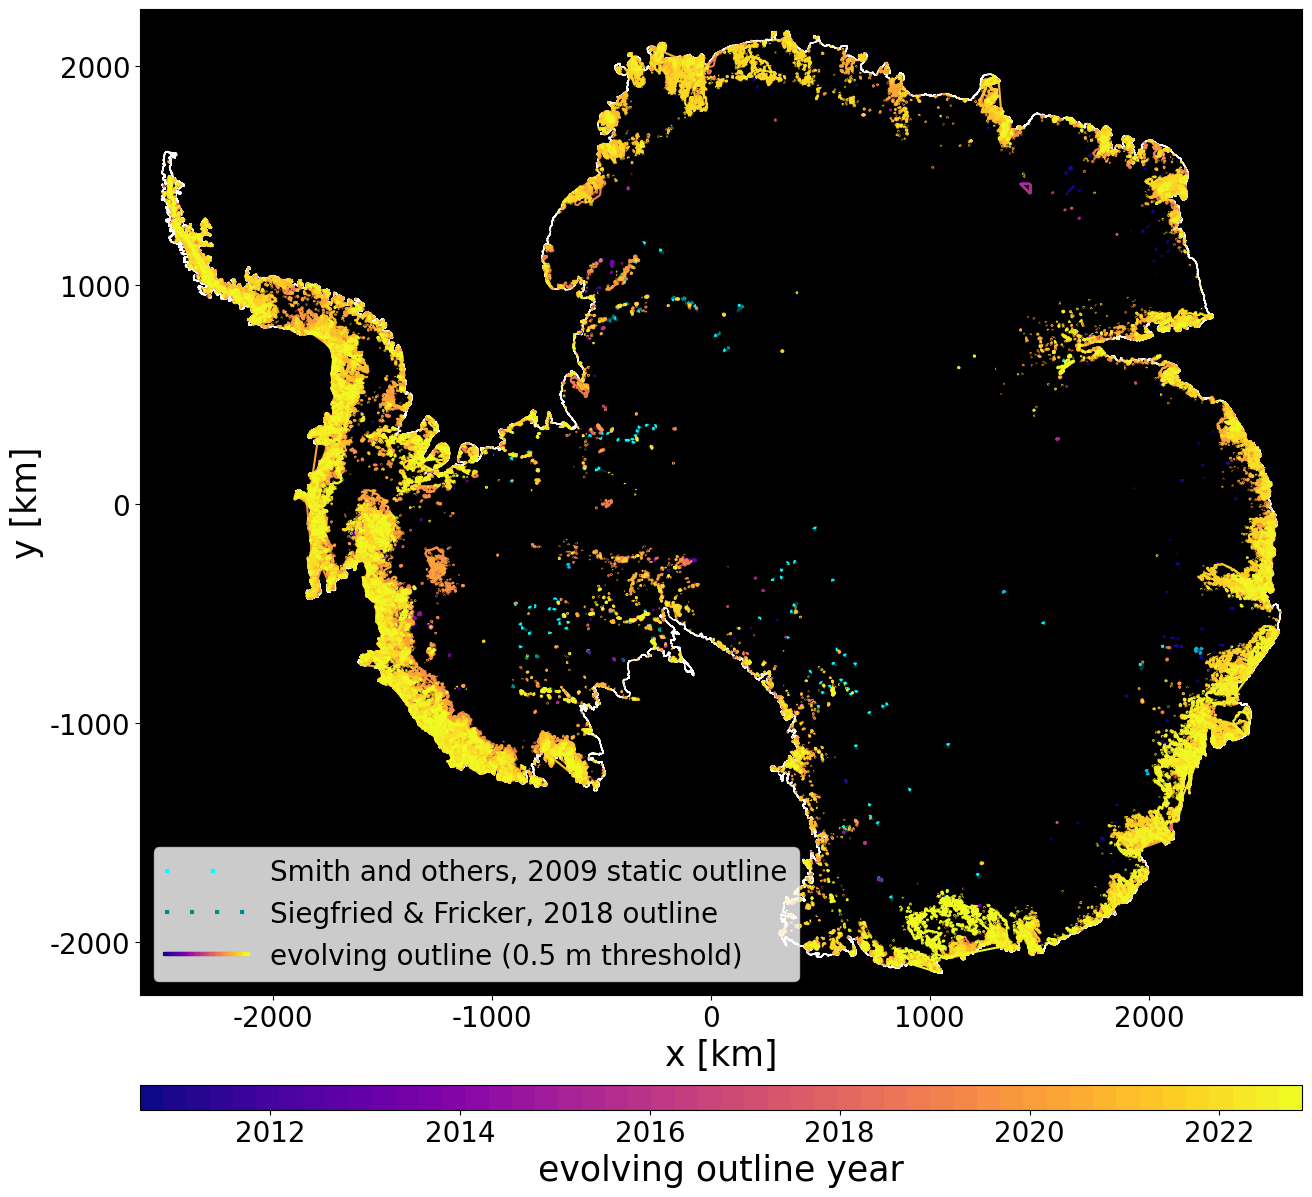

In [194]:
plot_evolving_outlines_time_series(gdf_subset, CS2_dh, ATL15)

In [ ]:
gdf_overlapping = find_overlapping_polygons(gdf)

In [ ]:
plot_evolving_outlines_time_series(gdf_overlapping, CS2_dh, ATL15_dh_A3)

In [137]:
gdf_overlapping_in_time = find_overlapping_polygons_in_time(gdf)

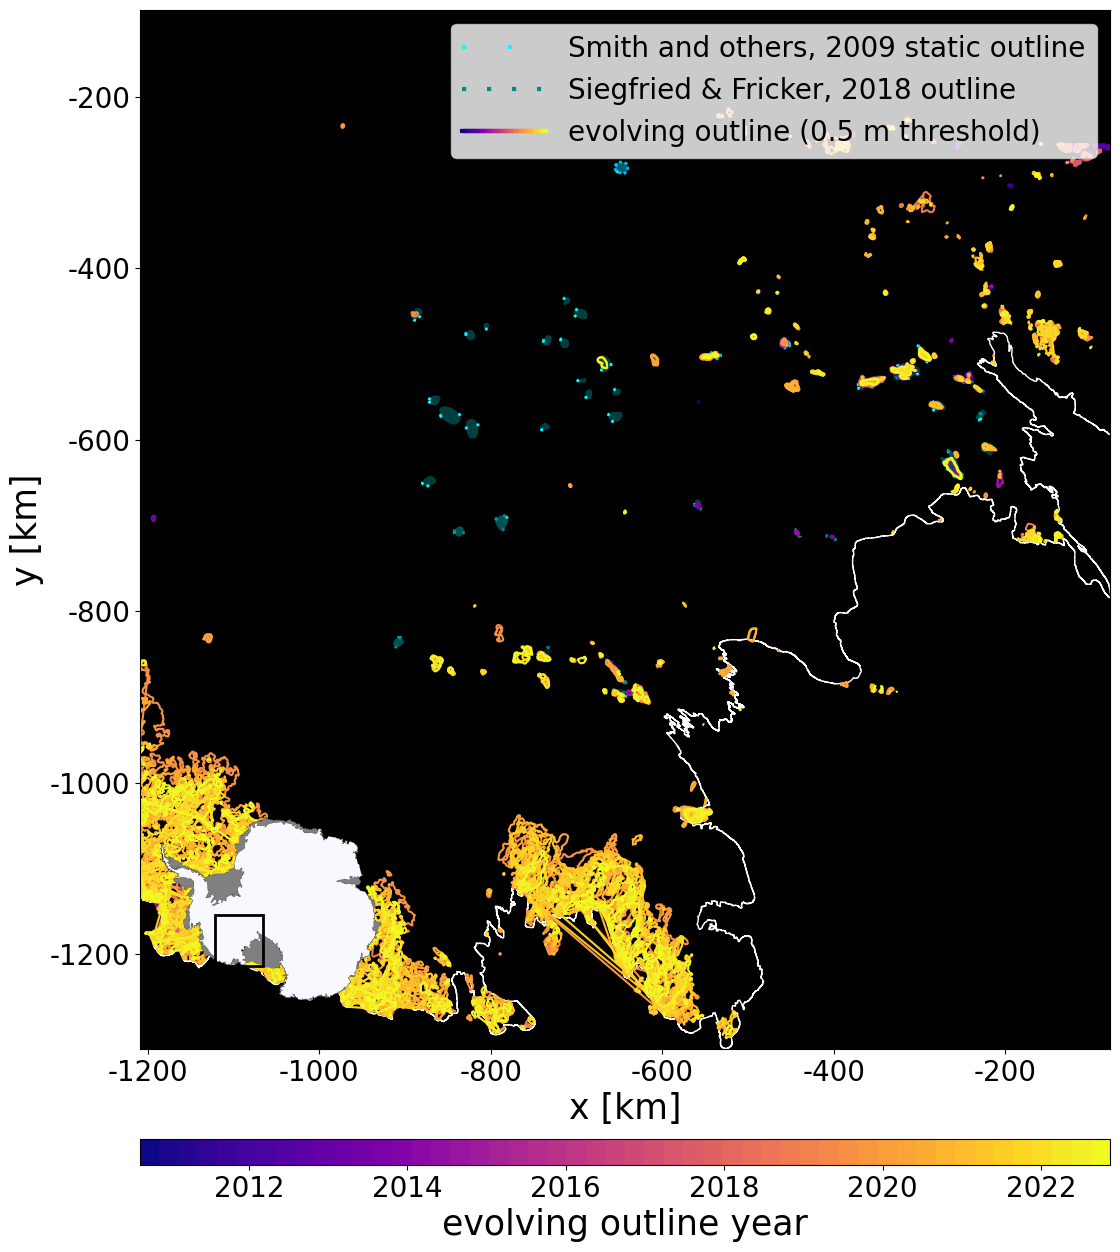

In [139]:
plot_evolving_outlines_time_series(gdf_overlapping_in_time, CS2_dh, ATL15)

In [140]:
gdf_intersecting = find_intersecting_polygons(gdf)

GEOSException: TopologyException: side location conflict at -757345.97194840433 -1124434.9719419554. This can occur if the input geometry is invalid.

In [ ]:
plot_evolving_outlines_time_series(gdf_intersecting, CS2_dh, ATL15)

In [141]:
gdf_intersecting_in_time = find_intersecting_polygons_in_time(gdf)

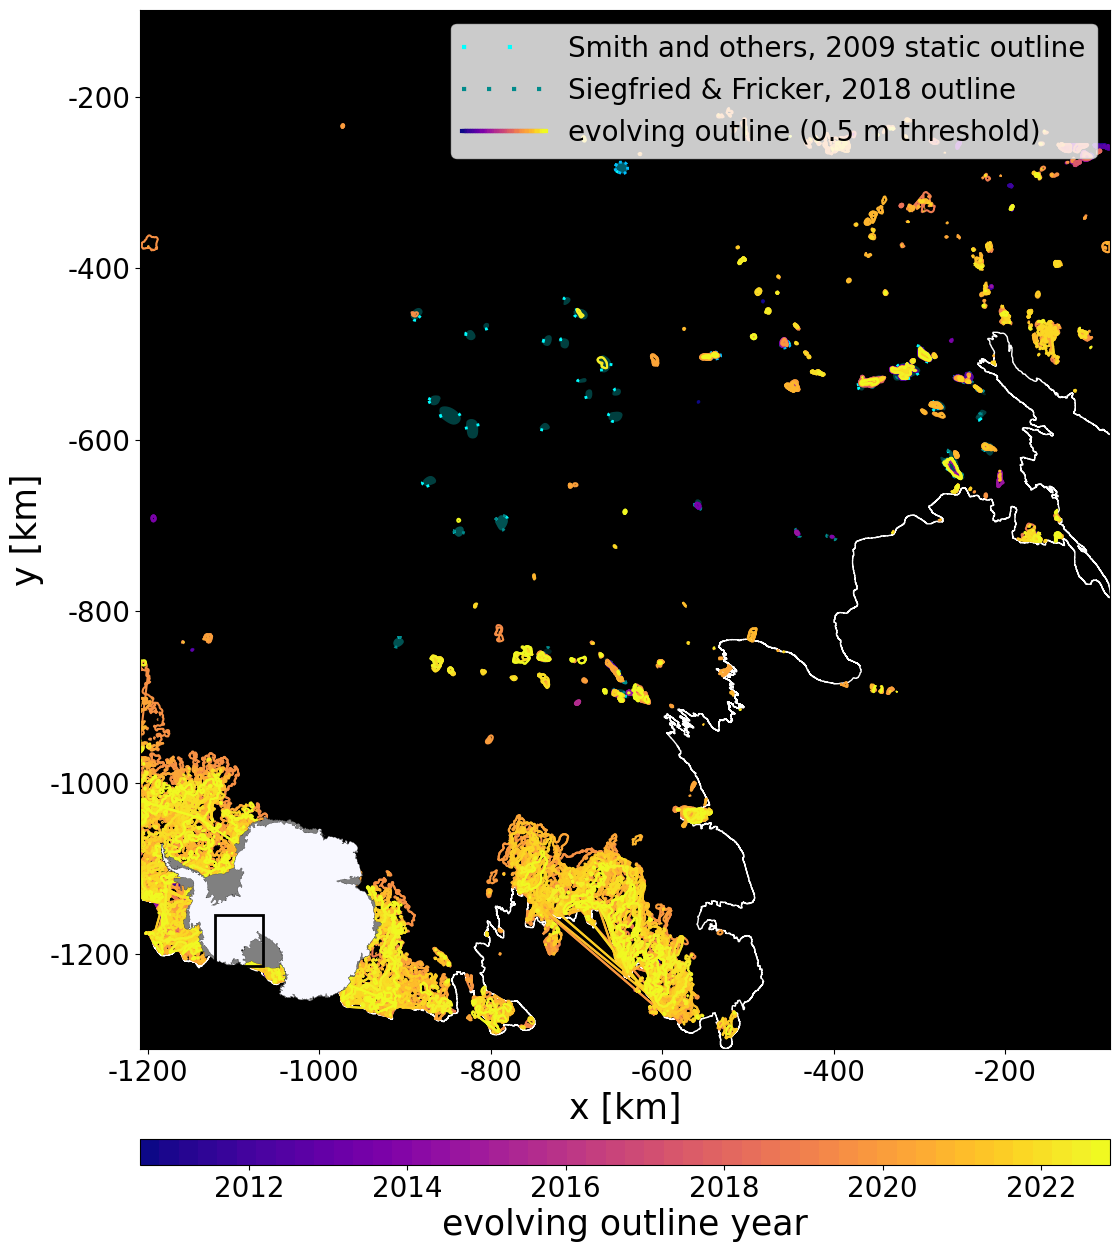

In [142]:
plot_evolving_outlines_time_series(gdf_intersecting_in_time, CS2_dh, ATL15)

## Trying Matt's suggested method of finding lake candidates:
* Start with larger threshold (e.g., 0.5, 0.4, 0.3)
* filter out non-intersecting and non-intersecting-in-time outlines
* cluster polygons into groups of lakes and lake candidates
* find the avg centroid of clusters of outlines
* from there, zoom into scene around previously identified lakes and lake candidates and use lower threshold (e.g. 0.2, 0.1) to capture as much signal as possible of lake
* you can find instances were two or more avg centroids should be merged as one lake with the following test:
* keep contour ATL15_dh_A3.x.min.valuesif one centroid within outline
* if two or more centroids within outline, then that is flag to investigate that outline more in depth to see if two or more avg centroids should be merged as one lake

In [51]:
# Manually select bbox coords of Kamb Truck
ROI = 'A3'
buffer = 10000
x_min, y_min = (ATL15_dh_A3.x.min().values, ATL15_dh_A3.y.min().values)
x_max, y_max = (ATL15_dh_A3.x.max().values, ATL15_dh_A3.y.max().values)

In [52]:
# create_dirs(['func_name'], base_directory=OUTPUT_DIR)

In [53]:
threshold = 0.5
gdf = find_evolving_outlines(ROI, x_min, x_max, y_min, y_max, threshold, buffer, CS2_dh, ATL15_dh_A3)

In [54]:
gdf

geometry  \
0      POLYGON ((-1820014.077 -302929.257, -1821013.5...   
1      POLYGON ((-1624120.195 -463548.780, -1623120.7...   
2      POLYGON ((-353808.338 -536781.512, -354807.796...   
3      POLYGON ((-1362262.047 -560734.354, -1363261.5...   
4      POLYGON ((-557697.888 -556903.553, -558697.347...   
...                                                  ...   
25208  POLYGON ((-816315.010 -1261037.376, -815627.27...   
25209  POLYGON ((-931292.256 -1262036.613, -930637.12...   
25210  POLYGON ((-910506.768 -1259775.482, -911506.22...   
25211  POLYGON ((-608670.276 -1263123.375, -609669.73...   
25212  POLYGON ((-846541.419 -1269480.246, -847540.87...   

       evolving area (km^2)  perim (km)            datetime  \
0                104.986694   46.927749 2010-08-17 06:45:00   
1                360.647529   74.335002 2010-08-17 06:45:00   
2                104.509942   48.548989 2010-08-17 06:45:00   
3                 60.172407   45.544426 2010-08-17 06:45:00   
4                  2.522130    5.906449 2010-08-17 06:45:00   
...                     ...         ...                 ...   
25208             22.785218   17.908349 2023-02-15 21:45:00   
25209              3.934456    7.560713 2023-02-15 21:45:00   
25210             48.073187   33.871179 2023-02-15 21:45:00   
25211             13.166177   17.498845 2023-02-15 21:45:00   
25212              5.033569   11.252375 2023-02-15 21:45:00   

                               centroid        date  
0      POINT (-1813327.041 -297275.851)  2010-08-17  
1      POINT (-1612072.394 -472124.097)  2010-08-17  
2       POINT (-359064.363 -532595.445)  2010-08-17  
3      POINT (-1356502.321 -555217.406)  2010-08-17  
4       POINT (-558074.034 -556095.753)  2010-08-17  
...                                 ...         ...  
25208  POINT (-818022.088 -1258792.600)  2023-02-15  
25209  POINT (-932068.803 -1261093.612)  2023-02-15  
25210  POINT (-916924.070 -1264531.198)  2023-02-15  
25211  POINT (-611160.019 -1265986.630)  2023-02-15  
25212  POINT (-849085.916 -1270667.334)  2023-02-15  

[25213 rows x 6 columns]

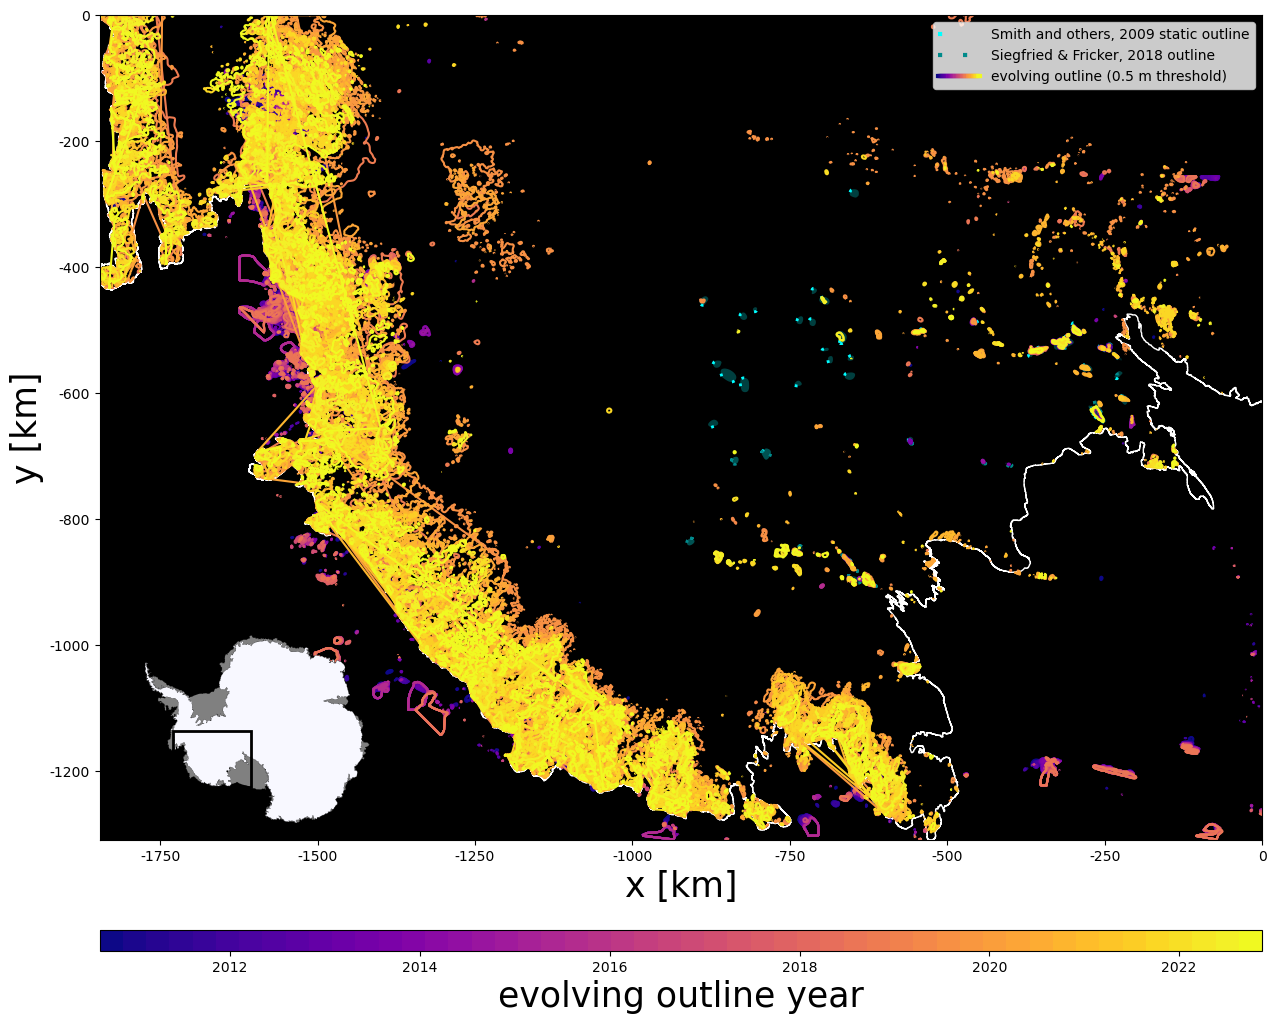

In [55]:
plot_evolving_outlines_time_series(gdf, CS2_dh, ATL15_dh_A3)

In [56]:
gdf_intersecting_in_time = find_intersecting_polygons_in_time(gdf)

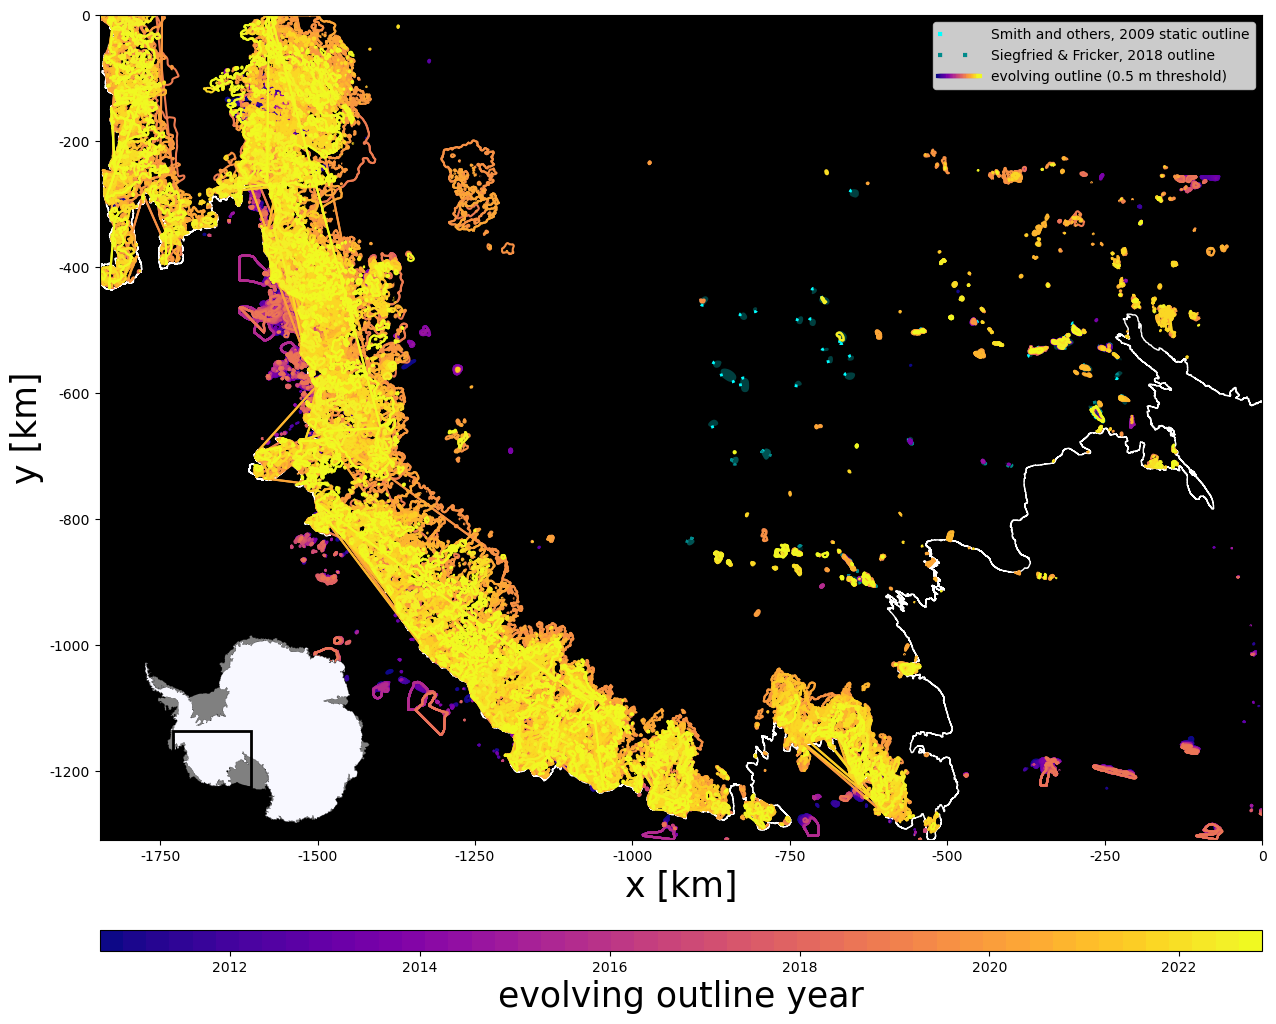

In [57]:
plot_evolving_outlines_time_series(gdf_intersecting_in_time, CS2_dh, ATL15_dh_A3)

## Alt strategy: 
* Integrated time signal for longer signal of lakes (rolling window?) or perhaps just a time series of cumulative height change and create contours around areas that exceed a threshold over course of the total time series
* write python code that will difference rasters contained xarray dataset by the time variable and keep a running tuple of two rasters that contains the min and max cumulative differences from one time step to the next

In [43]:
# Calculate differences and initialize min/max cumulative differences
diff = ATL15_dh_A3['delta_h'].diff(dim='time')
min_cumulative_diff = diff.min(dim='time', keep_attrs=True)
max_cumulative_diff = diff.max(dim='time', keep_attrs=True)

# Calculate cumulative differences and update min/max
for i in range(1, len(ATL15_dh_A3['time'])):
    cumulative_diff = diff.isel(time=slice(0, i + 1)).sum(dim='time')
    
    min_cumulative_diff = xr.where(cumulative_diff < min_cumulative_diff, cumulative_diff, min_cumulative_diff)
    max_cumulative_diff = xr.where(cumulative_diff > max_cumulative_diff, cumulative_diff, max_cumulative_diff)

# Create a new variable with min/max cumulative differences
ATL15_dh_A3['cumulative_diff'] = xr.concat([min_cumulative_diff, max_cumulative_diff], dim='cumulative_diff_dim')

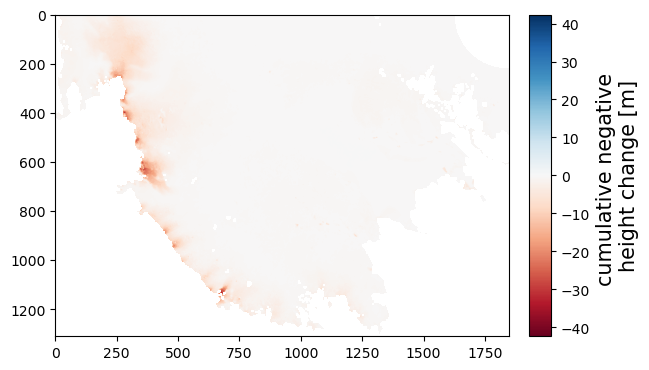

In [44]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['cumulative_diff'][0,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative negative \nheight change [m]', size=15)

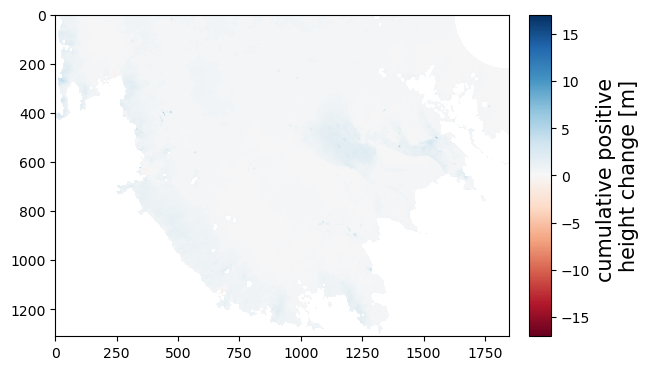

In [45]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['cumulative_diff'][1,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative positive \nheight change [m]', size=15)

In [47]:
# Calculate differences and initialize cumulative differences
diff = ATL15_dh_A3['delta_h'].diff(dim='time')

# Initialize cumulative difference variables
cumulative_diff_min = diff.isel(time=0)
cumulative_diff_max = diff.isel(time=0)

# Calculate cumulative differences
for i in range(1, len(ATL15_dh_A3['time'])-1):
    cumulative_diff_min += xr.where(diff.isel(time=i) < cumulative_diff_min, diff.isel(time=i), 0)
    cumulative_diff_max += xr.where(diff.isel(time=i) > cumulative_diff_max, diff.isel(time=i), 0)

# Create a new variable with cumulative differences
ATL15_dh_A3['cumulative_diff_2'] = xr.concat([cumulative_diff_min, cumulative_diff_max], dim='cumulative_diff_dim')

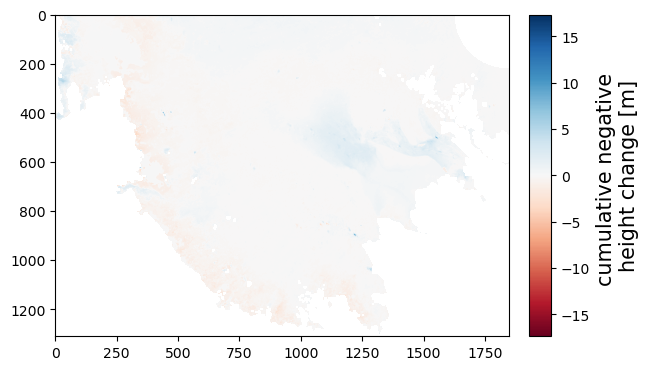

In [51]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['cumulative_diff_2'][0,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative negative \nheight change [m]', size=15)

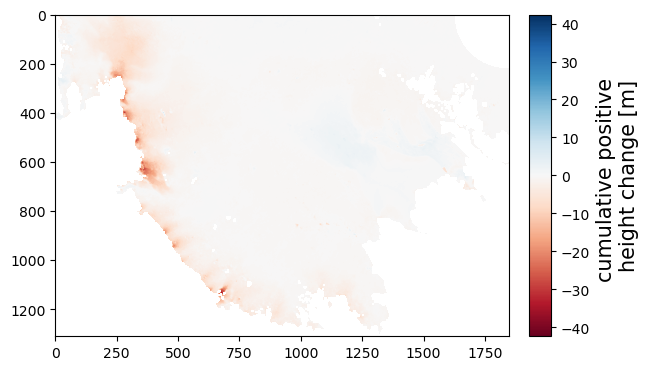

In [42]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['cumulative_diff_2'][1,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative positive \nheight change [m]', size=15)

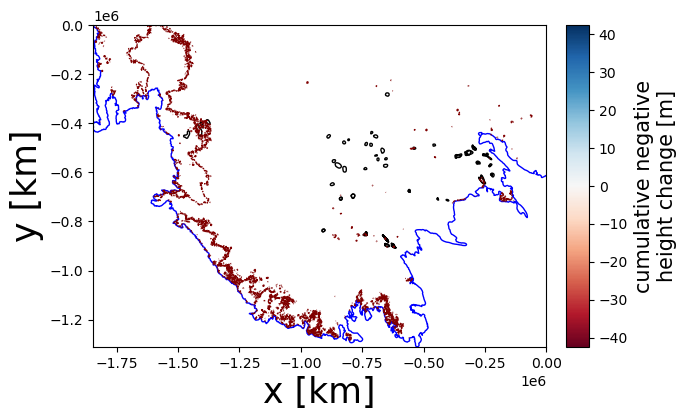

In [77]:
threshold = 3
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['cumulative_diff_2'][0,:,:], norm=colors.CenteredNorm(), cmap='RdBu')

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

img = ax.imshow(ATL15_dh_A3['cumulative_diff_2'][0,:,:],
                extent=[x_min, x_max, y_min, y_max], origin='lower',
                norm=colors.CenteredNorm(), cmap='RdBu')

contours_pos = measure.find_contours(ATL15_dh_A3['cumulative_diff_2'][0,:,:].values, threshold)
contours_neg = measure.find_contours(ATL15_dh_A3['cumulative_diff_2'][0,:,:].values, -threshold)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
x_conv = (x_max-x_min)/ATL15_dh_A3['cumulative_diff_2'][0,:,:].shape[1]
y_conv = (y_max-y_min)/ATL15_dh_A3['cumulative_diff_2'][0,:,:].shape[0]
# for i in range(len(contours_pos)):
#     x = x_min+contours_pos[i][:,1]*x_conv
#     y = y_max-contours_pos[i][:,0]*y_conv
#     ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
for i in range(len(contours_neg)):
    x = x_min+contours_neg[i][:,1]*x_conv
    y = y_max-contours_neg[i][:,0]*y_conv
    ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative negative\nheight change [m]', size=15)

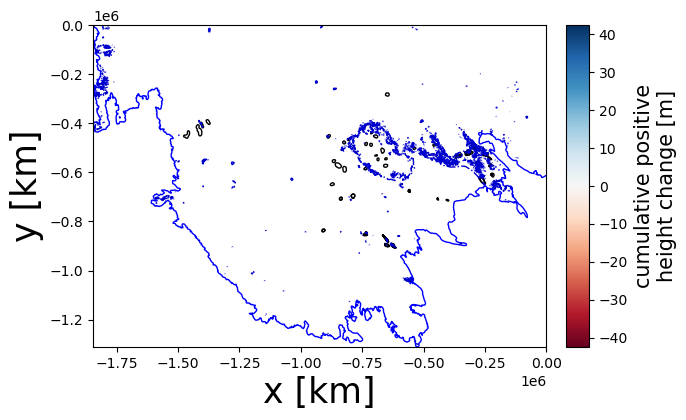

In [83]:
threshold = 1
# Visualize the result
fig, ax = plt.subplots()

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

img = ax.imshow(ATL15_dh_A3['cumulative_diff_2'][1,:,:], 
                extent=[x_min, x_max, y_min, y_max], origin='lower',
                norm=colors.CenteredNorm(), cmap='RdBu')

contours_pos = measure.find_contours(ATL15_dh_A3['cumulative_diff_2'][0,:,:].values, threshold)
contours_neg = measure.find_contours(ATL15_dh_A3['cumulative_diff_2'][0,:,:].values, -threshold)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
x_conv = (x_max-x_min)/ATL15_dh_A3['cumulative_diff_2'][0,:,:].shape[1]
y_conv = (y_max-y_min)/ATL15_dh_A3['cumulative_diff_2'][0,:,:].shape[0]
for i in range(len(contours_pos)):
    x = x_min+contours_pos[i][:,1]*x_conv
    y = y_max-contours_pos[i][:,0]*y_conv
    ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
# for i in range(len(contours_neg)):
#     x = x_min+contours_neg[i][:,1]*x_conv
#     y = y_max-contours_neg[i][:,0]*y_conv
#     ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative positive\nheight change [m]', size=15)

In [49]:
ATL15_dh_A3['test'] = ATL15_dh_A3['cumulative_diff_2'] - ATL15_dh_A3['cumulative_diff']

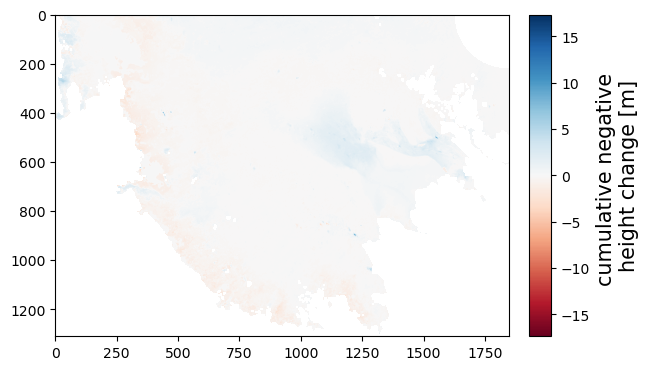

In [52]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['test'][0,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative negative \nheight change [m]', size=15)

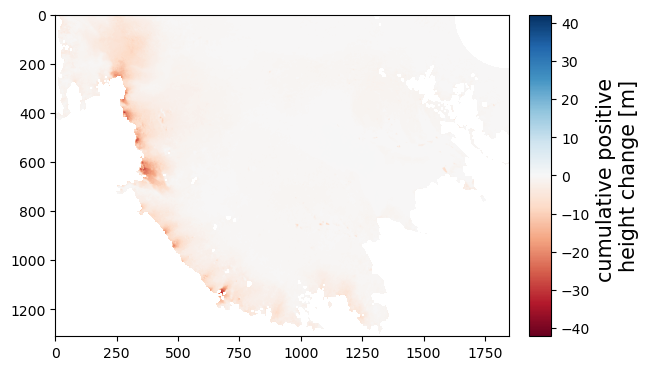

In [53]:
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['test'][1,:,:], norm=colors.CenteredNorm(), cmap='RdBu')
# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative positive \nheight change [m]', size=15)

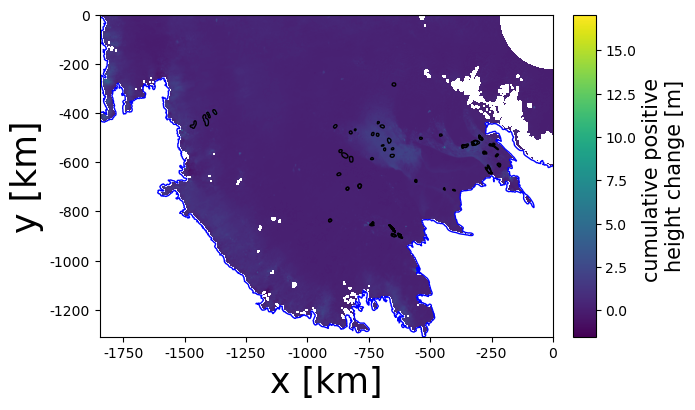

In [84]:
# Visualize the result
fig, ax = plt.subplots()

# Overlay published active lake outlines for visual comparison and grounding line
S09_color = 'cyan'
SF18_color  = 'darkcyan'
S23_color = 'deepskyblue'
S09_color = 'k'
SF18_color  = 'k'
S23_color = 'k'
# Smith2009_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle='solid', linewidth=1)
# SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 5)), linewidth=2, alpha=0.25)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle='solid', linewidth=1)
# Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Change polar stereographic m to km for cleaner-looking axes labels
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_aspect('equal')

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

img = ax.imshow(ATL15_dh_A3['cumulative_diff'][1,:,:], 
    extent=[x_min, x_max, y_min, y_max], 
    origin='lower')

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('cumulative positive \nheight change [m]', size=15)

In [ ]:
# Investigating chatgpt code to see if working properly

In [21]:
# Creating small synthetic example to ensure code is working properly
import numpy as np
import pandas as pd
import xarray as xr

# Create sample data
x_values = np.linspace(1, 3, 3)
y_values = np.linspace(1, 3, 3)
time_values = pd.date_range("2023-01-01", periods=5, freq="D")
data_values = np.array(
    [[[0, .2, 0],
    [.2, .4, .2],
    [0, .2, 0]],
                       
    [[0, .3, 0],
    [.3, .5, .3],
    [0, .3, 0]],
                       
    [[0, -.2, 0],
    [-.2, -.4, -.2],
    [0, -.2, 0]],
                       
    [[0, -.3, 0],
    [-.3, -.5, -.3],
    [0, -.3, 0]],
                       
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]]])

# Create xarray dataset
ds = xr.Dataset(
    {
        "data": (["time", "y", "x"], data_values),
    },
    coords={
        "x": x_values,
        "y": y_values,
        "time": time_values,
    },
)

# View the dataset
ds

<xarray.Dataset>
Dimensions:  (time: 5, y: 3, x: 3)
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
Data variables:
    data     (time, y, x) float64 0.0 0.2 0.0 0.2 0.4 ... 0.0 0.0 0.0 0.0 0.0

In [80]:
diff = ds['data'].diff(dim='time')
diff

<xarray.DataArray 'data' (time: 4, y: 3, x: 3)>
array([[[ 0. ,  0.1,  0. ],
        [ 0.1,  0.1,  0.1],
        [ 0. ,  0.1,  0. ]],

       [[ 0. , -0.5,  0. ],
        [-0.5, -0.9, -0.5],
        [ 0. , -0.5,  0. ]],

       [[ 0. , -0.1,  0. ],
        [-0.1, -0.1, -0.1],
        [ 0. , -0.1,  0. ]],

       [[ 0. ,  0.3,  0. ],
        [ 0.3,  0.5,  0.3],
        [ 0. ,  0.3,  0. ]]])
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0
  * time     (time) datetime64[ns] 2023-01-02 2023-01-03 2023-01-04 2023-01-05

In [8]:
# Creating small synthetic example to ensure code is working properly
import numpy as np
import pandas as pd
import xarray as xr

# Create sample data
x_values = np.linspace(1, 3, 3)
y_values = np.linspace(1, 3, 3)
time_values = pd.date_range("2023-01-01", periods=5, freq="D")
data_values = np.array(
    [[[0, .2, 0],
    [.2, -.4, .2],
    [0, .2, 0]],
                       
    [[0, .3, 0],
    [.3, -.5, .3],
    [0, .3, 0]],
                       
    [[0, -.2, 0],
    [-.2, .4, -.2],
    [0, -.2, 0]],
                       
    [[0, -.3, 0],
    [-.3, .5, -.3],
    [0, -.3, 0]],
                       
    [[0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]]])

# Create xarray dataset
ds = xr.Dataset(
    {
        "data": (["time", "y", "x"], data_values),
    },
    coords={
        "x": x_values,
        "y": y_values,
        "time": time_values,
    },
)

# View the dataset
ds

<xarray.Dataset>
Dimensions:  (time: 5, y: 3, x: 3)
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
Data variables:
    data     (time, y, x) float64 0.0 0.2 0.0 0.2 -0.4 ... 0.0 0.0 0.0 0.0 0.0

In [ ]:
# Calculate differences and initialize min/max cumulative differences
cumsum = ds['data'].cumsum(dim='time')
min_cumsum = cumsum.min(dim='time', keep_attrs=True)
max_cumsum = cumsum.max(dim='time', keep_attrs=True)
print(min_cumsum)
print(max_cumsum)

# # Calculate cumulative differences and update min/max
# for i in range(1, len(ds['data'])):
#     cumulative_diff = diff.isel(time=slice(0, i + 1)).sum(dim='time')
#     # print(cumulative_diff)
#     min_cumulative_diff = xr.where(cumulative_diff < min_cumulative_diff, cumulative_diff, min_cumulative_diff)
#     max_cumulative_diff = xr.where(cumulative_diff > max_cumulative_diff, cumulative_diff, max_cumulative_diff)

# # Create a new variable with min/max cumulative differences
# ds['cumulative_diff'] = xr.concat([min_cumulative_diff, max_cumulative_diff], dim='cumulative_diff_dim')

In [54]:
# Calculate differences and initialize min/max cumulative differences

# print(min_cumsum)
# print(max_cumsum)
min_cumsums = []
max_cumsums = []

# Calculate cumulative differences and update min/max
for i in range(0, len(ds['data'])):
    cumsum = ds['data'][i:,:,:].cumsum(dim='time')
    min_cumsum = cumsum.min(dim='time', keep_attrs=True)
    min_cumsums.append(min_cumsum)
    max_cumsum = cumsum.max(dim='time', keep_attrs=True)
    max_cumsums.append(max_cumsum)
    
min_cumsums_da = xr.concat(min_cumsums, dim='time')
max_cumsums_da = xr.concat(max_cumsums, dim='time')

grand_min_cumsum = min_cumsums_da.min(dim='time', keep_attrs=True)
grand_max_cumsum = max_cumsums_da.max(dim='time', keep_attrs=True)

# Create a new variable with min/max cumulative differences
ds['grand_cumsum'] = xr.concat([grand_min_cumsum, grand_max_cumsum], dim='grand_cumsum')

In [48]:
min_cumsums_da

<xarray.DataArray 'data' (time: 5, y: 3, x: 3)>
array([[[ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ]],

       [[ 0. , -0.2,  0. ],
        [-0.2, -0.4, -0.2],
        [ 0. , -0.2,  0. ]],

       [[ 0. , -0.5,  0. ],
        [-0.5, -0.9, -0.5],
        [ 0. , -0.5,  0. ]],

       [[ 0. , -0.3,  0. ],
        [-0.3, -0.5, -0.3],
        [ 0. , -0.3,  0. ]],

       [[ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ]]])
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0
Dimensions without coordinates: time

In [52]:
min_cumsums_da.min(dim='time', keep_attrs=True)

<xarray.DataArray 'data' (y: 3, x: 3)>
array([[ 0. , -0.5,  0. ],
       [-0.5, -0.9, -0.5],
       [ 0. , -0.5,  0. ]])
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0

In [51]:
max_cumsums_da

<xarray.DataArray 'data' (time: 5, y: 3, x: 3)>
array([[[ 0. ,  0.5,  0. ],
        [ 0.5,  0.9,  0.5],
        [ 0. ,  0.5,  0. ]],

       [[ 0. ,  0.3,  0. ],
        [ 0.3,  0.5,  0.3],
        [ 0. ,  0.3,  0. ]],

       [[ 0. , -0.2,  0. ],
        [-0.2, -0.4, -0.2],
        [ 0. , -0.2,  0. ]],

       [[ 0. , -0.3,  0. ],
        [-0.3, -0.5, -0.3],
        [ 0. , -0.3,  0. ]],

       [[ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ]]])
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0
Dimensions without coordinates: time

In [53]:
max_cumsums_da.max(dim='time', keep_attrs=True)

<xarray.DataArray 'data' (y: 3, x: 3)>
array([[0. , 0.5, 0. ],
       [0.5, 0.9, 0.5],
       [0. , 0.5, 0. ]])
Coordinates:
  * x        (x) float64 1.0 2.0 3.0
  * y        (y) float64 1.0 2.0 3.0

In [55]:
ds['grand_cumsum'] 

<xarray.DataArray 'grand_cumsum' (grand_cumsum: 2, y: 3, x: 3)>
array([[[ 0. , -0.5,  0. ],
        [-0.5, -0.9, -0.5],
        [ 0. , -0.5,  0. ]],

       [[ 0. ,  0.5,  0. ],
        [ 0.5,  0.9,  0.5],
        [ 0. ,  0.5,  0. ]]])
Coordinates:
  * x             (x) float64 1.0 2.0 3.0
  * y             (y) float64 1.0 2.0 3.0
    grand_cumsum  (grand_cumsum, y, x) float64 0.0 -0.5 0.0 -0.5 ... 0.0 0.5 0.0

In [81]:
# Trying with actual data

In [94]:
ATL15_dh_A3['dh'] = ATL15_dh_A3['delta_h'].diff(dim='time')

In [96]:
ATL15_dh_A3['dh']

<xarray.Dataset>
Dimensions:              (time: 19, x: 1847, y: 1311)
Coordinates:
  * time                 (time) float64 273.9 365.2 ... 1.826e+03 1.918e+03
  * x                    (x) float64 -1.846e+06 -1.845e+06 ... -1e+03 0.0
  * y                    (y) float64 0.0 -1e+03 -2e+03 ... -1.309e+06 -1.31e+06
    Polar_Stereographic  int64 0
    spatial_ref          int64 0
Data variables:
    ice_area             (time, y, x) float32 nan 1.012e+06 ... nan nan
    delta_h              (time, y, x) float32 nan 0.6688 0.5822 ... nan nan nan
    delta_h_sigma        (time, y, x) float32 nan 0.07068 0.07086 ... nan nan
    data_count           (time, y, x) float32 nan 0.008972 nan ... nan nan nan
    misfit_rms           (time, y, x) float32 nan 0.00238 nan ... nan nan nan
    misfit_scaled_rms    (time, y, x) float32 nan 0.2861 nan nan ... nan nan nan
    dh                   (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes: (12/115)
    description:                        This data set (ATL15) contains season...
    identifier:                         SET_BY_PGE
    pulse_rate:                         10000 pps
    type:                               SET_BY_META
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            SET_BY_META
    time_coverage_duration:             127871867.64814
    time_coverage_end:                  2023-04-16T23:57:48.648140Z
    time_coverage_start:                2019-03-29T00:00:01.000000Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [97]:
# Calculate differences and initialize min/max cumulative differences

# print(min_cumsum)
# print(max_cumsum)
min_cumsums = []
max_cumsums = []

# Calculate cumulative differences and update min/max
for i in range(0, len(ATL15_dh_A3['dh'])):
    cumsum = ATL15_dh_A3['dh'][i:,:,:].cumsum(dim='time')
    min_cumsum = cumsum.min(dim='time', keep_attrs=True)
    min_cumsums.append(min_cumsum)
    max_cumsum = cumsum.max(dim='time', keep_attrs=True)
    max_cumsums.append(max_cumsum)
    
min_cumsums_da = xr.concat(min_cumsums, dim='time')
max_cumsums_da = xr.concat(max_cumsums, dim='time')

grand_min_cumsum = min_cumsums_da.min(dim='time', keep_attrs=True)
grand_max_cumsum = max_cumsums_da.max(dim='time', keep_attrs=True)

# Create a new variable with min/max cumulative differences
ATL15_dh_A3['dh_grand_cumsum'] = xr.concat([grand_min_cumsum, grand_max_cumsum], dim='dh_grand_cumsum')

In [98]:
ATL15_dh_A3['dh_grand_cumsum']

<xarray.DataArray 'dh_grand_cumsum' (dh_grand_cumsum: 2, y: 1311, x: 1847)>
array([[[ 0.        , -0.8635864 , -0.8679199 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.8272095 , -0.83776855, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.8033447 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.8442993 ,  1.1761475 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.92492676,  1.3962402 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.7266846 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * x                    (x) float64 -1.846e+06 -1.845e+06 ... -1e+03 0.0
  * y                    (y) float64 0.0 -1e+03 -2e+03 ... -1.309e+06 -1.31e+06
    Polar_Stereographic  int64 0
    spatial_ref          int64 0
    dh_grand_cumsum      (dh_grand_cumsum, y, x) float32 0.0 -0.8636 ... 0.0 0.0

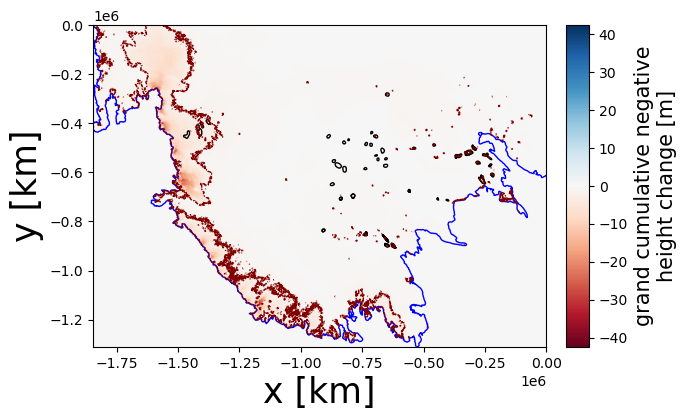

In [112]:
threshold = 2
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['dh_grand_cumsum'][0,:,:], 
                extent=[x_min, x_max, y_min, y_max], origin='lower',
                norm=colors.CenteredNorm(), cmap='RdBu')

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

contours_pos = measure.find_contours(ATL15_dh_A3['dh_grand_cumsum'][1,:,:].values, threshold)
contours_neg = measure.find_contours(ATL15_dh_A3['dh_grand_cumsum'][0,:,:].values, -threshold)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
x_conv = (x_max-x_min)/ATL15_dh_A3['dh_grand_cumsum'][0,:,:].shape[1]
y_conv = (y_max-y_min)/ATL15_dh_A3['dh_grand_cumsum'][0,:,:].shape[0]
# for i in range(len(contours_pos)):
#     x = x_min+contours_pos[i][:,1]*x_conv
#     y = y_max-contours_pos[i][:,0]*y_conv
#     ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
for i in range(len(contours_neg)):
    x = x_min+contours_neg[i][:,1]*x_conv
    y = y_max-contours_neg[i][:,0]*y_conv
    ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('grand cumulative negative\nheight change [m]', size=15)

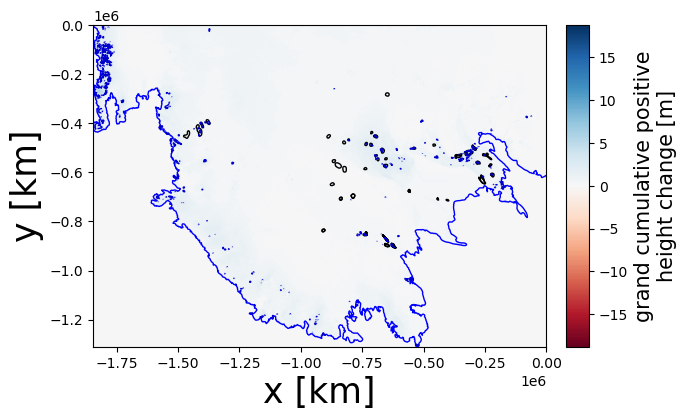

In [126]:
threshold = 2.5
# Visualize the result
fig, ax = plt.subplots()
img = ax.imshow(ATL15_dh_A3['dh_grand_cumsum'][1,:,:], 
                extent=[x_min, x_max, y_min, y_max], origin='lower',
                norm=colors.CenteredNorm(), cmap='RdBu')

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

contours_pos = measure.find_contours(ATL15_dh_A3['dh_grand_cumsum'][1,:,:].values, threshold)
contours_neg = measure.find_contours(ATL15_dh_A3['dh_grand_cumsum'][0,:,:].values, -threshold)
x_min, x_max = (ATL15_dh_A3['x'].min().values, ATL15_dh_A3['x'].max().values)
y_min, y_max = (ATL15_dh_A3['y'].min().values, ATL15_dh_A3['y'].max().values)
x_conv = (x_max-x_min)/ATL15_dh_A3['dh_grand_cumsum'][0,:,:].shape[1]
y_conv = (y_max-y_min)/ATL15_dh_A3['dh_grand_cumsum'][0,:,:].shape[0]
for i in range(len(contours_pos)):
    x = x_min+contours_pos[i][:,1]*x_conv
    y = y_max-contours_pos[i][:,0]*y_conv
    ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=threshold)
# for i in range(len(contours_neg)):
#     x = x_min+contours_neg[i][:,1]*x_conv
#     y = y_max-contours_neg[i][:,0]*y_conv
#     ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-threshold)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('grand cumulative positive\nheight change [m]', size=15)

In [35]:
# Trying continent wide with func's
find_cumsums(ATL15_dh)

In [36]:
gdf_5m = find_candidates(ATL15_dh, 5)

In [37]:
gdf_5m

geometry  area (km^2)  \
0     POLYGON ((1077474.445 1869067.178, 1077298.297...     0.037228   
1     POLYGON ((1357586.996 1662115.295, 1357559.827...     6.658975   
2     POLYGON ((1833541.454 1614126.453, 1833150.323...     0.067848   
3     POLYGON ((-2472214.441 1560139.005, -2472006.8...    29.932734   
4     POLYGON ((-497193.902 1527146.676, -496393.619...     3.221123   
...                                                 ...          ...   
1025  POLYGON ((1767161.284 -1875383.871, 1766161.48...     4.928585   
1026  POLYGON ((1713171.854 -1895209.559, 1712172.04...     5.014003   
1027  POLYGON ((1272258.172 -1973160.886, 1272218.11...     0.015237   
1028  POLYGON ((1229266.588 -1989054.766, 1228266.78...     0.186509   
1029  POLYGON ((1127286.553 -2047893.238, 1126286.74...     3.430370   

      perim (km) min_or_max                          centroid  
0       0.808470        min   POINT (1077303.916 1869050.283)  
1      10.109249        min   POINT (1355942.976 1663206.682)  
2       1.173846        min   POINT (1833253.230 1614083.909)  
3      20.628232        min  POINT (-2474235.008 1562568.003)  
4       6.772657        min   POINT (-497120.459 1528121.404)  
...          ...        ...                               ...  
1025    9.474251        max  POINT (1765938.085 -1874568.590)  
1026    8.306186        max  POINT (1711872.122 -1894430.412)  
1027    0.520706        max  POINT (1272281.524 -1973051.006)  
1028    2.386170        max  POINT (1228815.073 -1988996.231)  
1029    7.474371        max  POINT (1127267.898 -2046502.831)  

[1030 rows x 5 columns]

In [47]:
# basic stats on areas
print(gdf_5m['area (km^2)'].max())
print(gdf_5m['area (km^2)'].median())

37675.68004235086
1.8761761621252595


In [50]:
# consults matt’s inventory for median and max areas to find cut off to occlude larger area contours
print(SiegfriedFricker2018_outlines['area (m^2)'].max()/1e6)
print(SiegfriedFricker2018_outlines['area (m^2)'].median()/1e6)

1257.8696642202933
150.25004974152517


In [61]:
print(SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['area (m^2)'] == SiegfriedFricker2018_outlines['area (m^2)'].max()])

        name                                           geometry    area (m^2)  \
97  Nimrod_2  POLYGON ((379048.308 -468526.253, 379290.572 -...  1.257870e+09   

    perimeter (m)                                               cite  
97  183270.656278  Smith and others, 2009, J. Glac., doi:10.3189/...  


In [54]:
SiegfriedFricker2018_outlines

name                                           geometry  \
0    Bindschadler_1  POLYGON ((-792264.327 -691480.857, -791281.458...   
1    Bindschadler_2  POLYGON ((-842788.063 -708464.240, -842354.948...   
2    Bindschadler_3  POLYGON ((-874893.221 -654533.044, -876415.673...   
3    Bindschadler_4  POLYGON ((-828821.778 -584874.415, -828822.032...   
4    Bindschadler_5  POLYGON ((-858067.460 -573467.564, -858714.391...   
..              ...                                                ...   
126      Whillans_6  POLYGON ((-451544.869 -488823.261, -451209.964...   
127      Whillans_7  POLYGON ((-543163.376 -500759.165, -542800.367...   
128      Whillans_8  POLYGON ((-654478.748 -281124.560, -653777.327...   
129        Wilkes_1  POLYGON ((2214185.180 -666018.604, 2214317.389...   
130        Wilkes_2  POLYGON ((1985649.483 -1222665.850, 1986964.16...   

       area (m^2)  perimeter (m)  \
0    1.943146e+08   51147.562479   
1    1.072249e+08   37249.152584   
2    1.404559e+08   44183.483257   
3    2.816411e+08   62680.016773   
4    3.923966e+08   73686.203194   
..            ...            ...   
126  7.458477e+07   31952.842516   
127  7.696570e+07   32373.996995   
128  1.625714e+08   45873.974279   
129  5.880773e+08   89565.314574   
130  1.766583e+08   48307.837257   

                                                  cite  
0    Smith and others, 2009, J. Glac., doi:10.3189/...  
1    Smith and others, 2009, J. Glac., doi:10.3189/...  
2    Smith and others, 2009, J. Glac., doi:10.3189/...  
3    Smith and others, 2009, J. Glac., doi:10.3189/...  
4    Smith and others, 2009, J. Glac., doi:10.3189/...  
..                                                 ...  
126  Smith and others, 2009, J. Glac., doi:10.3189/...  
127  Smith and others, 2009, J. Glac., doi:10.3189/...  
128  Smith and others, 2009, J. Glac., doi:10.3189/...  
129  Smith and others, 2009, J. Glac., doi:10.3189/...  
130  Smith and others, 2009, J. Glac., doi:10.3189/...  

[131 rows x 5 columns]

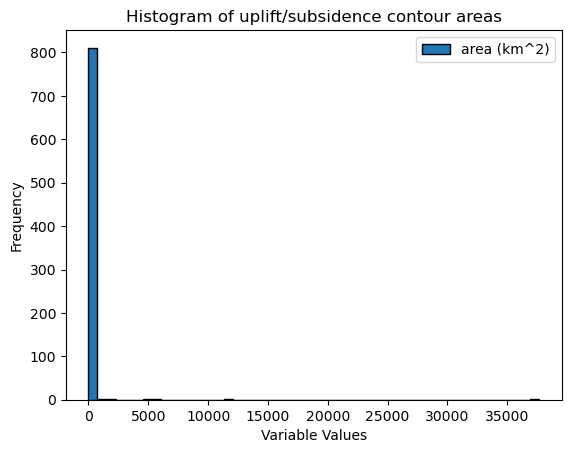

In [68]:
# Plot histo of outline areas; find cutoff area to remove large outliers
gdf_5m[gdf_5m['min_or_max'] == 'min']['area (km^2)'].plot.hist(bins=50, edgecolor='black')

# Add labels and title
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram of uplift/subsidence contour areas')

# Add legend
plt.legend()

# Show the plot
plt.show()

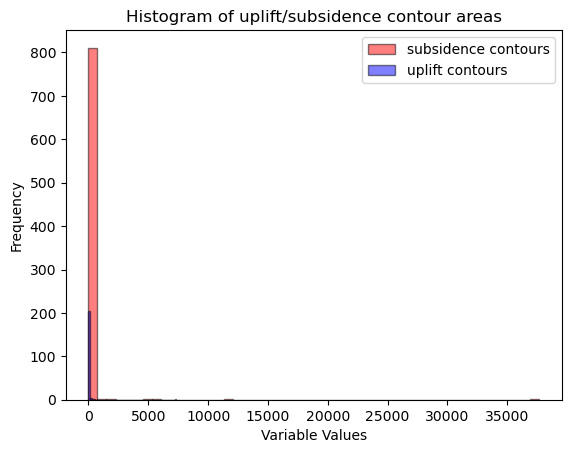

In [238]:
# Plot histogram for variable_name2 in orange with 50% opacity
gdf_5m[gdf_5m['min_or_max'] == 'min']['area (km^2)'].plot.hist(bins=50, edgecolor='black', color='red', alpha=0.5, label='subsidence contours')
gdf_5m[gdf_5m['min_or_max'] == 'max']['area (km^2)'].plot.hist(bins=50, edgecolor='black', color='blue', alpha=0.5, label='uplift contours')

# Add labels and title
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram of uplift/subsidence contour areas')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [70]:
gdf_5m_subset = gdf_5m[gdf_5m['area (km^2)'] <= (SiegfriedFricker2018_outlines['area (m^2)'].max()/1e6)]
gdf_5m_subset

geometry  area (km^2)  \
0     POLYGON ((1077474.445 1869067.178, 1077298.297...     0.037228   
1     POLYGON ((1357586.996 1662115.295, 1357559.827...     6.658975   
2     POLYGON ((1833541.454 1614126.453, 1833150.323...     0.067848   
3     POLYGON ((-2472214.441 1560139.005, -2472006.8...    29.932734   
4     POLYGON ((-497193.902 1527146.676, -496393.619...     3.221123   
...                                                 ...          ...   
1025  POLYGON ((1767161.284 -1875383.871, 1766161.48...     4.928585   
1026  POLYGON ((1713171.854 -1895209.559, 1712172.04...     5.014003   
1027  POLYGON ((1272258.172 -1973160.886, 1272218.11...     0.015237   
1028  POLYGON ((1229266.588 -1989054.766, 1228266.78...     0.186509   
1029  POLYGON ((1127286.553 -2047893.238, 1126286.74...     3.430370   

      perim (km) min_or_max                          centroid  
0       0.808470        min   POINT (1077303.916 1869050.283)  
1      10.109249        min   POINT (1355942.976 1663206.682)  
2       1.173846        min   POINT (1833253.230 1614083.909)  
3      20.628232        min  POINT (-2474235.008 1562568.003)  
4       6.772657        min   POINT (-497120.459 1528121.404)  
...          ...        ...                               ...  
1025    9.474251        max  POINT (1765938.085 -1874568.590)  
1026    8.306186        max  POINT (1711872.122 -1894430.412)  
1027    0.520706        max  POINT (1272281.524 -1973051.006)  
1028    2.386170        max  POINT (1228815.073 -1988996.231)  
1029    7.474371        max  POINT (1127267.898 -2046502.831)  

[1024 rows x 5 columns]

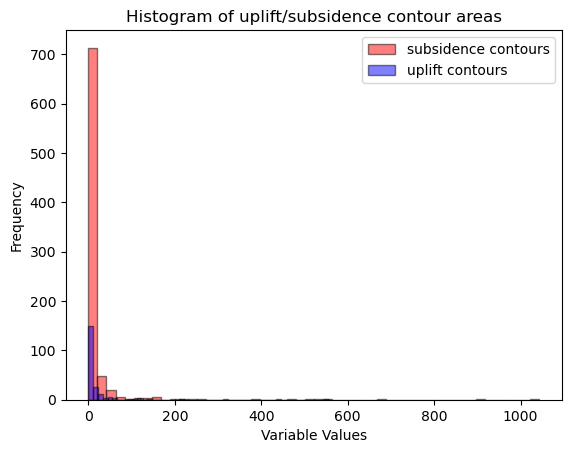

In [304]:
# Plot histogram for variable_name2 in orange with 50% opacity
gdf_5m_subset[gdf_5m_subset['min_or_max'] == 'min']['area (km^2)'].plot.hist(bins=50, edgecolor='black', color='red', alpha=0.5, label='subsidence contours')
gdf_5m_subset[gdf_5m_subset['min_or_max'] == 'max']['area (km^2)'].plot.hist(bins=50, edgecolor='black', color='blue', alpha=0.5, label='uplift contours')

# Add labels and title
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram of uplift/subsidence contour areas')

# Add legend
plt.legend()

# Show the plot
plt.show()

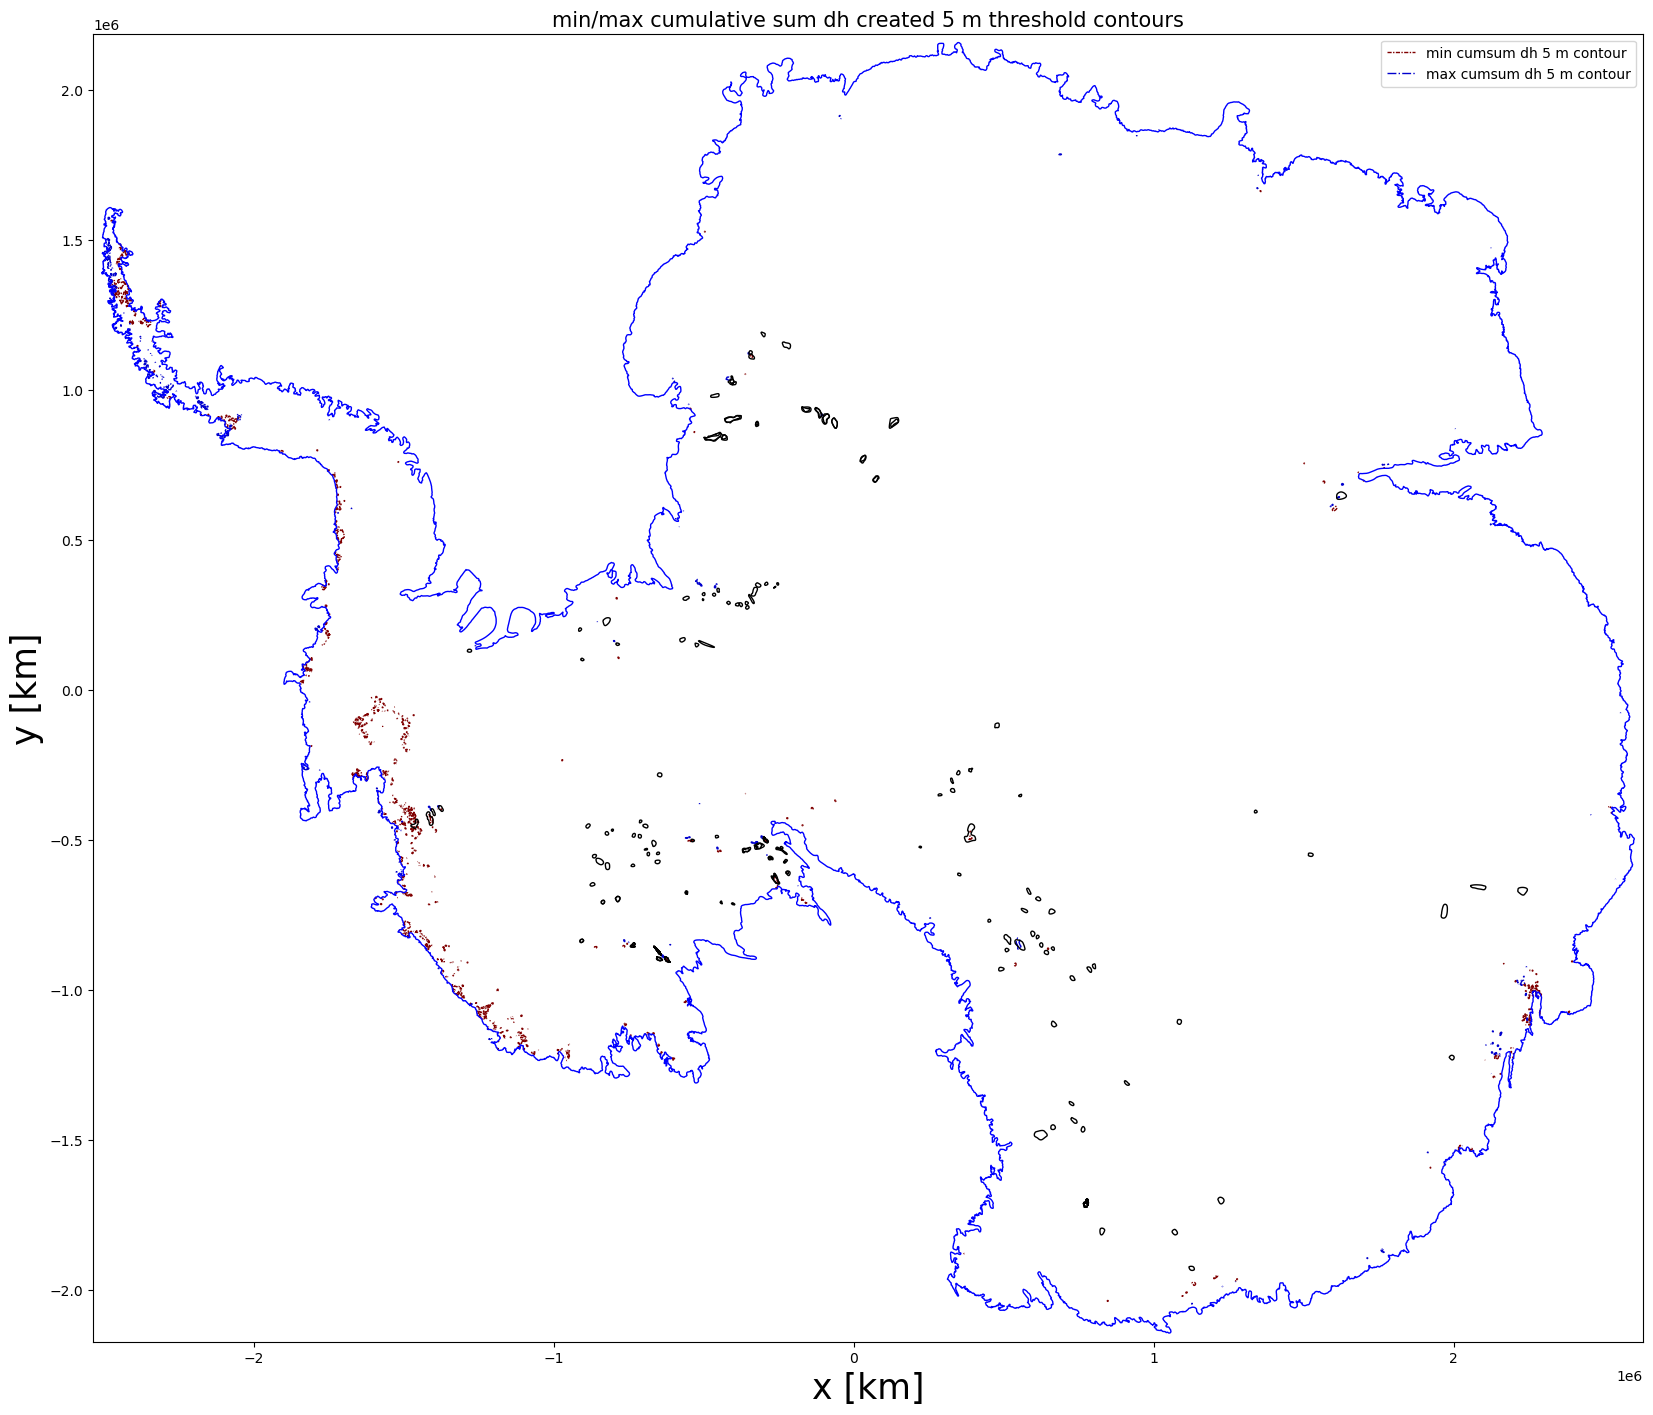

In [219]:
plot_candidates(ATL15_dh, 5, gdf_5m_subset)

In [ ]:
# later: investigate the large outlines to see if any look lake like

In [177]:
# Remove outlines with centroids within previously identified lakes

# Assuming you have two GeoDataFrames: gdf_points and gdf_polygons
gdf_points = gdf_5m_subset
gdf_polygons = SiegfriedFricker2018_outlines

# Perform a spatial join based on the centroid of gdf_points within gdf_polygons
# joined = gpd.sjoin(gdf_points, gdf_polygons, op='within')
joined = gdf_points.sjoin(gdf_polygons, how="inner", predicate='intersects')

# Extract the indices of rows in gdf_points that do not have a match in the join
rows_to_remove = joined.index

# Remove the rows from gdf_points
gdf_points_cleaned = gdf_points.drop(rows_to_remove)

In [ ]:
# rows_to_remove = joined.index_right
# doesn't work; investigate why different?

In [161]:
joined.index

Int64Index([ 48,  48, 858, 352, 950, 372, 375, 383, 394, 401, 408, 412, 413,
            418, 430, 439, 444, 963, 445, 478, 484, 550, 564, 988, 880, 902,
            920, 952, 981, 985, 986, 987],
           dtype='int64')

In [167]:
joined.index_right

48     113
48     114
858    114
352    119
950    119
372    117
375    117
383    120
394    120
401    120
408    120
412    120
413    120
418    120
430     97
439     97
444     93
963     93
445    127
478     81
484     41
550     88
564     85
988     85
880    112
902    106
920     83
952    118
981      7
985     87
986     87
987     87
Name: index_right, dtype: int64

In [166]:
len(joined.index)

32

In [165]:
len(joined.index_right)

32

In [173]:
len(gdf_points)-32

992

In [187]:
len(gdf_points)-len(joined.index_right)

992

In [186]:
len(gdf_points)

1024

In [216]:
gdf_points

geometry  area (km^2)  \
0     POLYGON ((1077474.445 1869067.178, 1077298.297...     0.037228   
1     POLYGON ((1357586.996 1662115.295, 1357559.827...     6.658975   
2     POLYGON ((1833541.454 1614126.453, 1833150.323...     0.067848   
3     POLYGON ((-2472214.441 1560139.005, -2472006.8...    29.932734   
4     POLYGON ((-497193.902 1527146.676, -496393.619...     3.221123   
...                                                 ...          ...   
1025  POLYGON ((1767161.284 -1875383.871, 1766161.48...     4.928585   
1026  POLYGON ((1713171.854 -1895209.559, 1712172.04...     5.014003   
1027  POLYGON ((1272258.172 -1973160.886, 1272218.11...     0.015237   
1028  POLYGON ((1229266.588 -1989054.766, 1228266.78...     0.186509   
1029  POLYGON ((1127286.553 -2047893.238, 1126286.74...     3.430370   

      perim (km) min_or_max                          centroid  
0       0.808470        min   POINT (1077303.916 1869050.283)  
1      10.109249        min   POINT (1355942.976 1663206.682)  
2       1.173846        min   POINT (1833253.230 1614083.909)  
3      20.628232        min  POINT (-2474235.008 1562568.003)  
4       6.772657        min   POINT (-497120.459 1528121.404)  
...          ...        ...                               ...  
1025    9.474251        max  POINT (1765938.085 -1874568.590)  
1026    8.306186        max  POINT (1711872.122 -1894430.412)  
1027    0.520706        max  POINT (1272281.524 -1973051.006)  
1028    2.386170        max  POINT (1228815.073 -1988996.231)  
1029    7.474371        max  POINT (1127267.898 -2046502.831)  

[1024 rows x 5 columns]

In [184]:
gdf_points_cleaned

geometry  area (km^2)  \
0     POLYGON ((1077474.445 1869067.178, 1077298.297...     0.037228   
1     POLYGON ((1357586.996 1662115.295, 1357559.827...     6.658975   
2     POLYGON ((1833541.454 1614126.453, 1833150.323...     0.067848   
3     POLYGON ((-2472214.441 1560139.005, -2472006.8...    29.932734   
4     POLYGON ((-497193.902 1527146.676, -496393.619...     3.221123   
...                                                 ...          ...   
1025  POLYGON ((1767161.284 -1875383.871, 1766161.48...     4.928585   
1026  POLYGON ((1713171.854 -1895209.559, 1712172.04...     5.014003   
1027  POLYGON ((1272258.172 -1973160.886, 1272218.11...     0.015237   
1028  POLYGON ((1229266.588 -1989054.766, 1228266.78...     0.186509   
1029  POLYGON ((1127286.553 -2047893.238, 1126286.74...     3.430370   

      perim (km) min_or_max                          centroid  
0       0.808470        min   POINT (1077303.916 1869050.283)  
1      10.109249        min   POINT (1355942.976 1663206.682)  
2       1.173846        min   POINT (1833253.230 1614083.909)  
3      20.628232        min  POINT (-2474235.008 1562568.003)  
4       6.772657        min   POINT (-497120.459 1528121.404)  
...          ...        ...                               ...  
1025    9.474251        max  POINT (1765938.085 -1874568.590)  
1026    8.306186        max  POINT (1711872.122 -1894430.412)  
1027    0.520706        max  POINT (1272281.524 -1973051.006)  
1028    2.386170        max  POINT (1228815.073 -1988996.231)  
1029    7.474371        max  POINT (1127267.898 -2046502.831)  

[993 rows x 5 columns]

In [188]:
# appears to be not removing one of the outlines based on the counts; perhaps because 48 is repeated twice but can only be removed once
# trying to plot to see how it can be in two lakes

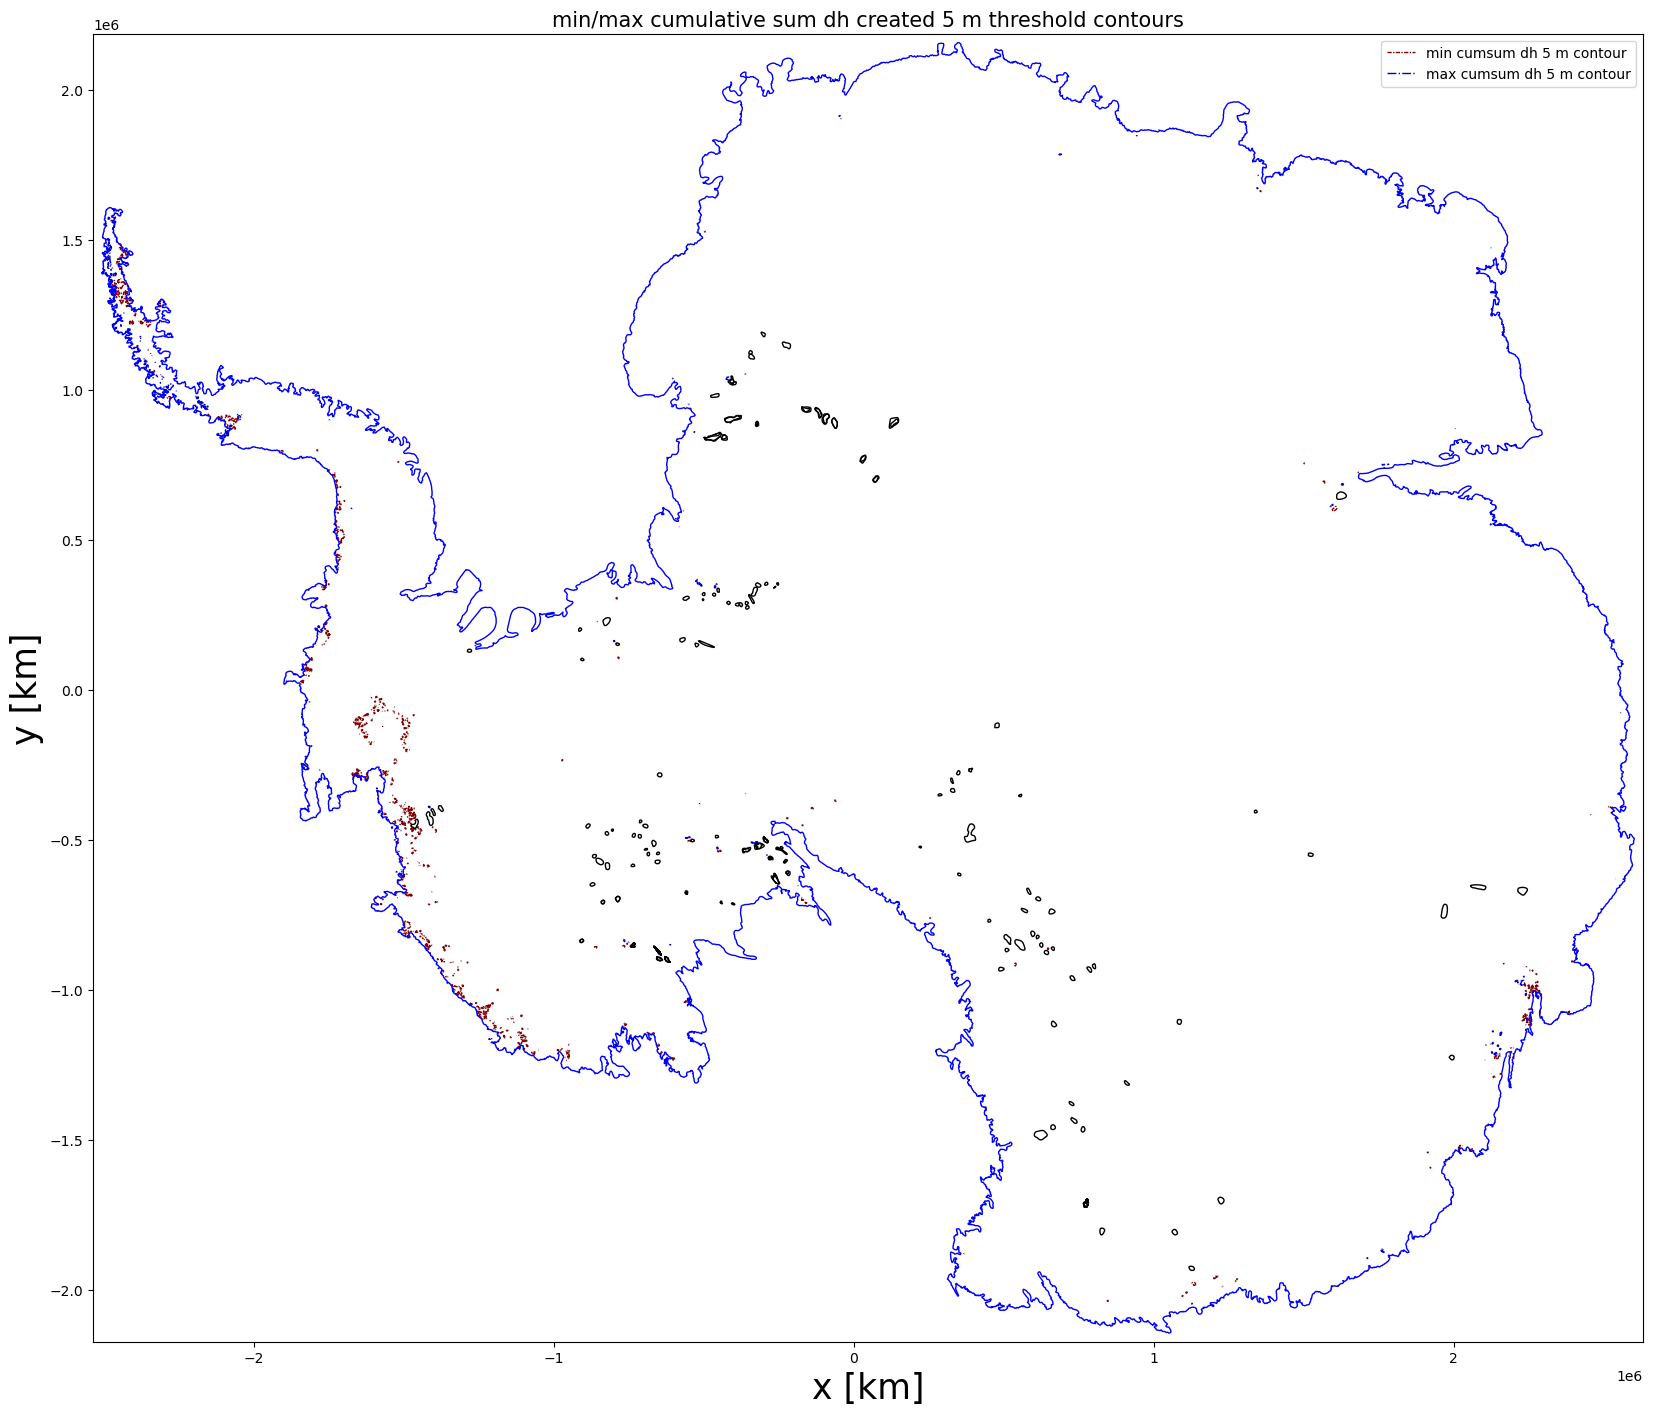

In [218]:
plot_candidates(ATL15_dh, 5, gdf_points_cleaned)

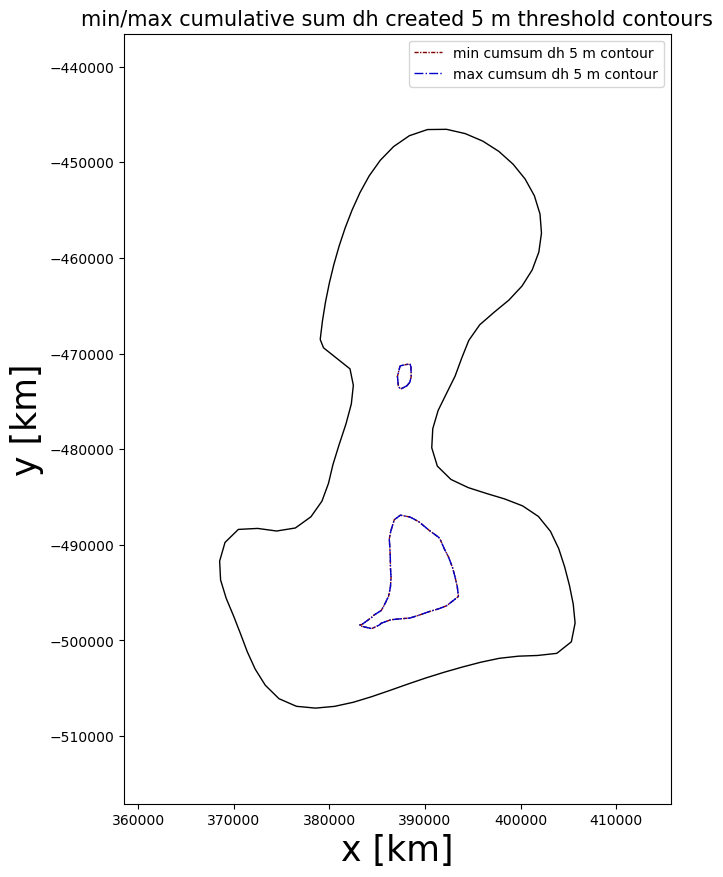

In [307]:
# investigate lake to see if outlines within previously identified lakes were removed
threshold = 5
lakename_S23 = 'Nimrod_2'
lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]
buffer = 10000
lake_buffer = lake_gpd.buffer(buffer)

# Define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

# Visualize the max grand cumulative sums 
fig, ax = plt.subplots(figsize=(10,10))

# # Plot the outlines
# gdf_points_cleaned.boundary.plot(ax=ax, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
#         linewidth=1, label='min cumsum dh {} m contour'.format(threshold))
# gdf_points_cleaned.boundary.plot(ax=ax, color='mediumblue', linestyle='dashdot', 
#         linewidth=1, label='max cumsum dh {} m contour'.format(threshold))

# Plot the outlines
gdf_points.boundary.plot(ax=ax, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
        linewidth=1, label='min cumsum dh {} m contour'.format(threshold))
gdf_points.boundary.plot(ax=ax, color='mediumblue', linestyle='dashdot', 
        linewidth=1, label='max cumsum dh {} m contour'.format(threshold))

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Add legend and title
ax.legend()
ax.set_title('min/max cumulative sum dh created {} m threshold contours'.format(threshold), size=15)
plt.show()

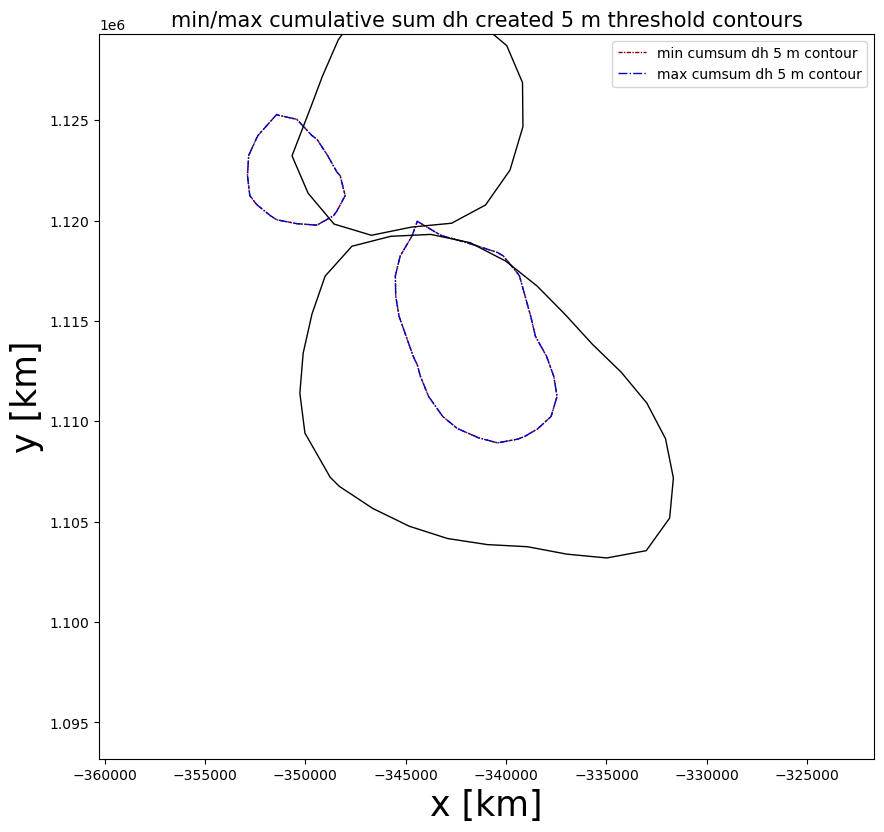

In [306]:
# investigate lake to see if outlines within previously identified lakes were removed
threshold = 5
lakename_S23 = 'Slessor_4'
lake_gpd = Sauthoff2023_outlines.loc[Sauthoff2023_outlines['name'] == lakename_S23]
buffer = 10000
lake_buffer = lake_gpd.buffer(buffer)

# Define lake bounding box
x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]

# Visualize the max grand cumulative sums 
fig, ax = plt.subplots(figsize=(10,10))

# # Plot the outlines
# gdf_points_cleaned.boundary.plot(ax=ax, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
#         linewidth=1, label='min cumsum dh {} m contour'.format(threshold))
# gdf_points_cleaned.boundary.plot(ax=ax, color='mediumblue', linestyle='dashdot', 
#         linewidth=1, label='max cumsum dh {} m contour'.format(threshold))

# Plot the outlines
gdf_points.boundary.plot(ax=ax, color='maroon', linestyle=(0, (3, 1, 1, 1)), 
        linewidth=1, label='min cumsum dh {} m contour'.format(threshold))
gdf_points.boundary.plot(ax=ax, color='mediumblue', linestyle='dashdot', 
        linewidth=1, label='max cumsum dh {} m contour'.format(threshold))

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Add legend and title
ax.legend()
ax.set_title('min/max cumulative sum dh created {} m threshold contours'.format(threshold), size=15)
plt.show()

In [ ]:
# finalizing algo

In [ ]:
find_cumsums(ATL15_dh)

threshold = 5
gdf = find_candidates(ATL15_dh, threshold)
print(len(gdf))
gdf_subset = gdf[gdf['area (km^2)'] <= (SiegfriedFricker2018_outlines['area (m^2)'].max()/1e6)]

In [349]:
# Remove outlines with centroids intersecting with previously identified lakes

# Assuming you have two GeoDataFrames
gdf_left = gdf_subset
gdf_left_reset = gdf_left.reset_index(drop=True)
gdf_right = SiegfriedFricker2018_outlines
gdf_right_reset = gdf_right.reset_index(drop=True)

# Perform a spatial join based on the centroid of gdf_points within gdf_polygons
# joined = gpd.sjoin(gdf_points, gdf_polygons, op='within')
joined = gdf_left_reset.sjoin(gdf_right_reset, how="inner", predicate='intersects')

# Extract the indices of rows in gdf_points that do not have a match in the join
rows_to_remove = joined.index

# Remove the rows from gdf_points
gdf_points_cleaned = gdf_left_reset.drop(rows_to_remove)

In [350]:
# Finding intersecting min/max outlines and ignore the rest

# making max the left gdf because more outlines in that gdf
gdf_left = gdf_points_cleaned[gdf_points_cleaned['min_or_max'] == 'min']
gdf_left_reset = gdf_left.reset_index(drop=True)
gdf_right = gdf_points_cleaned[gdf_points_cleaned['min_or_max'] == 'max']
gdf_right_reset = gdf_right.reset_index(drop=True)

# Perform a spatial join based on the centroid of gdf_points within gdf_polygons
# joined = gpd.sjoin(gdf_points, gdf_polygons, op='within')
joined = gdf_left_reset.sjoin(gdf_right_reset, how="inner", predicate='intersects')

# Extract the indices of rows in gdf_points that have a match in the join
left_rows_to_keep = joined.index
right_rows_to_keep = joined.index_right.values

# Remove the rows from gdf_points
gdf_left_cleaned_minmaxintersect = gdf_left_reset.iloc[left_rows_to_keep]
gdf_right_cleaned_minmaxintersect = gdf_right_reset.iloc[right_rows_to_keep]
gdf_cleaned_minmaxintersect = pd.concat([gdf_left_cleaned_minmaxintersect, gdf_right_cleaned_minmaxintersect], ignore_index=True)

In [351]:
len(gdf_cleaned_minmaxintersect)

5010

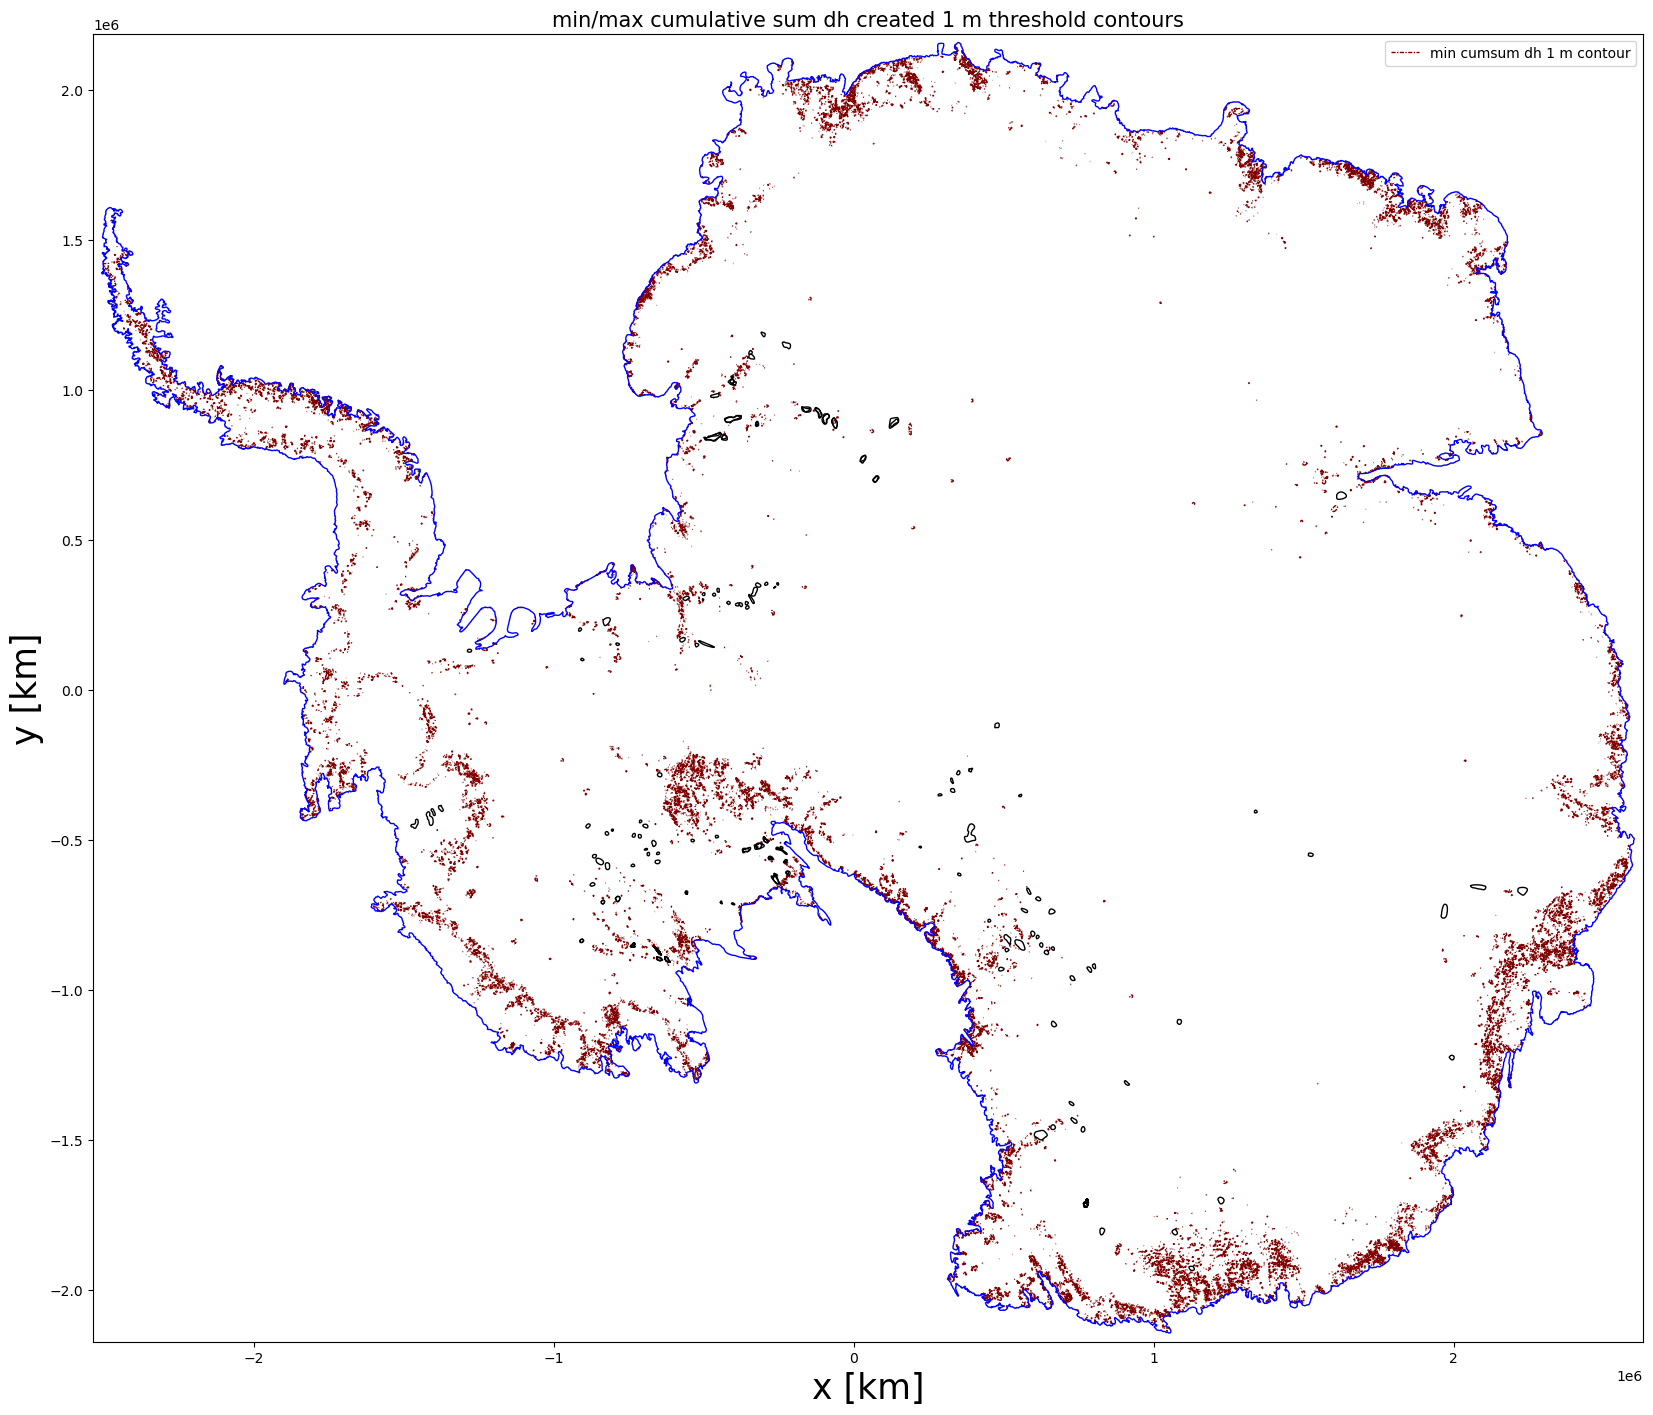

In [352]:
plot_candidates(ATL15_dh, threshold, gdf_left_reset)

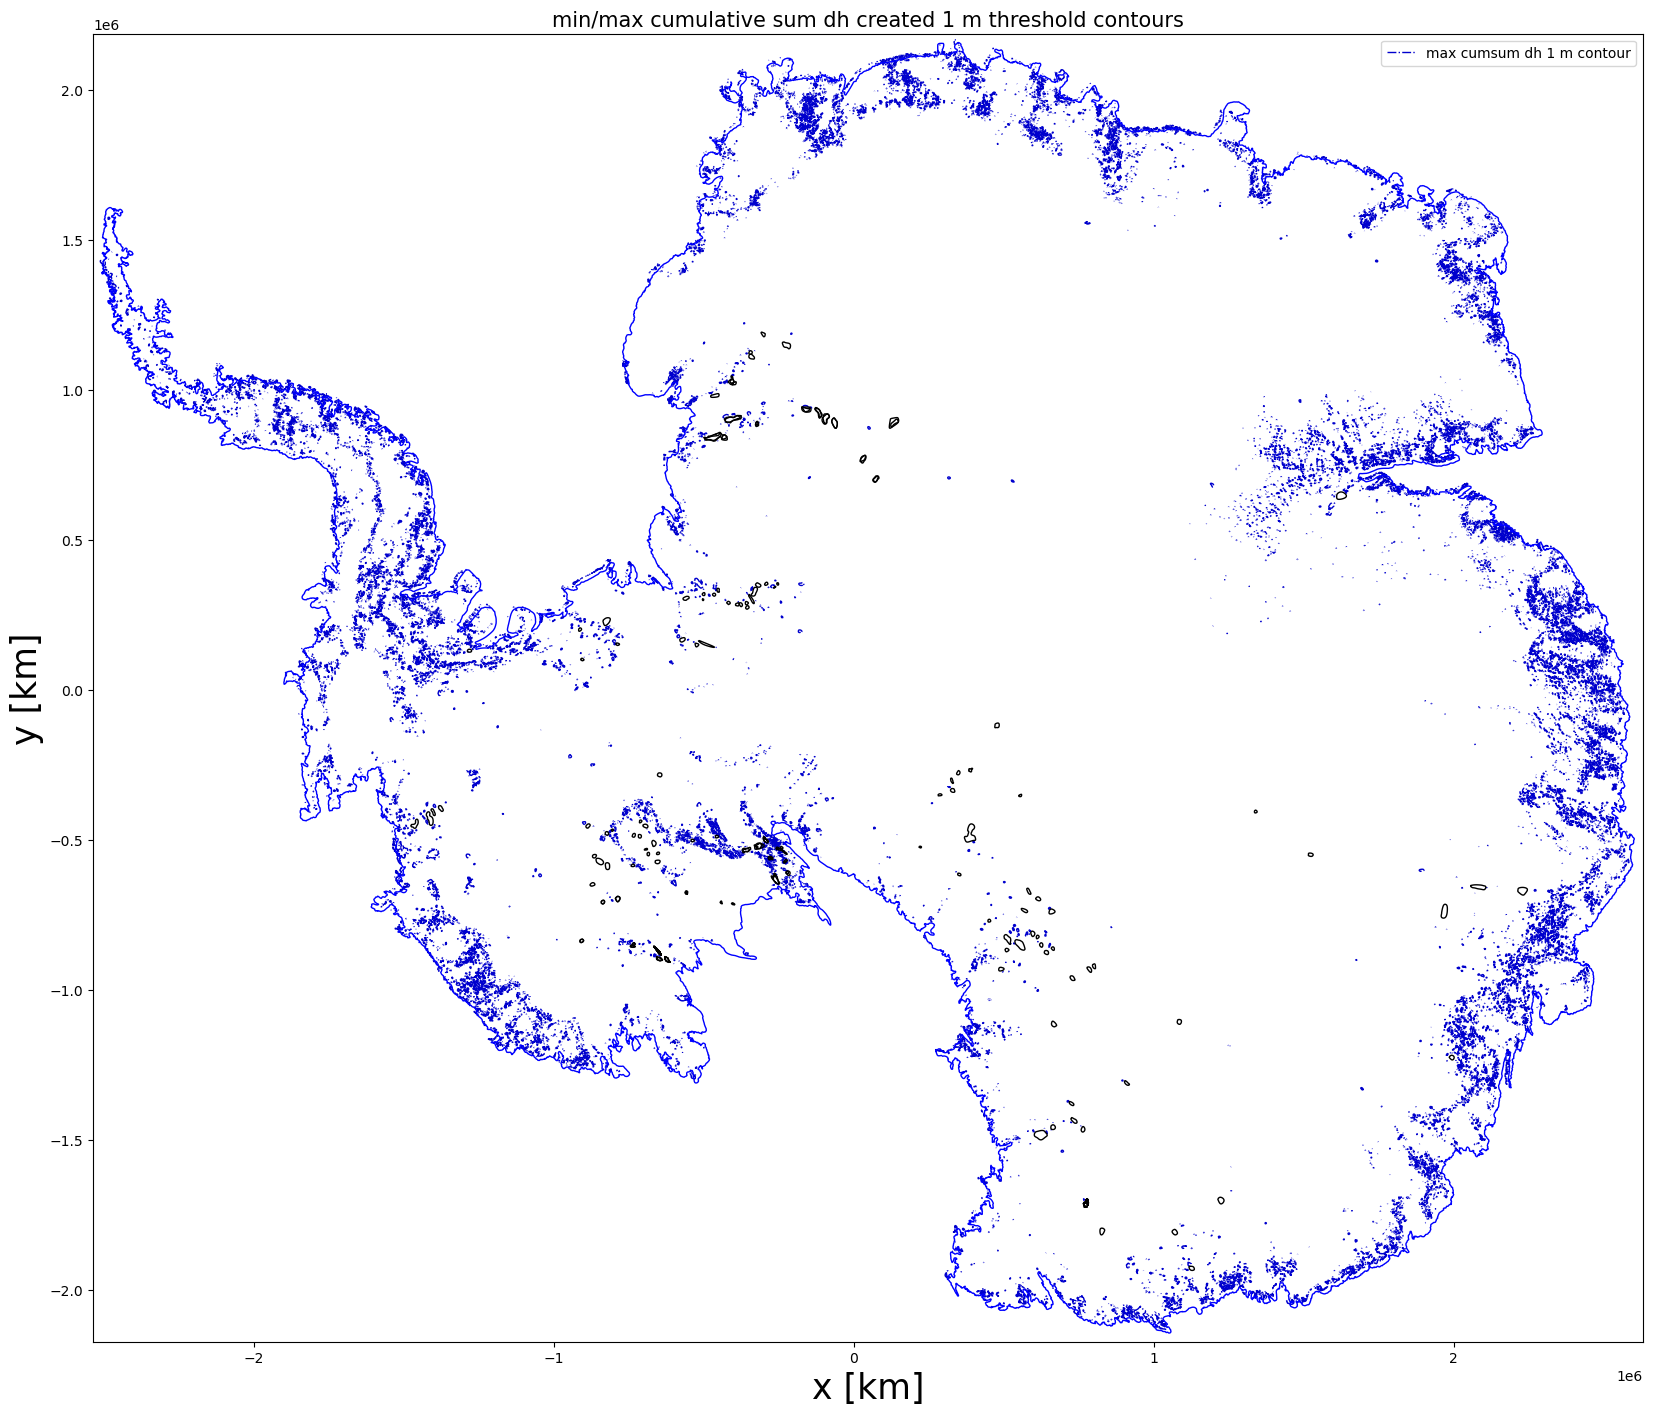

In [353]:
plot_candidates(ATL15_dh, threshold, gdf_right_reset)

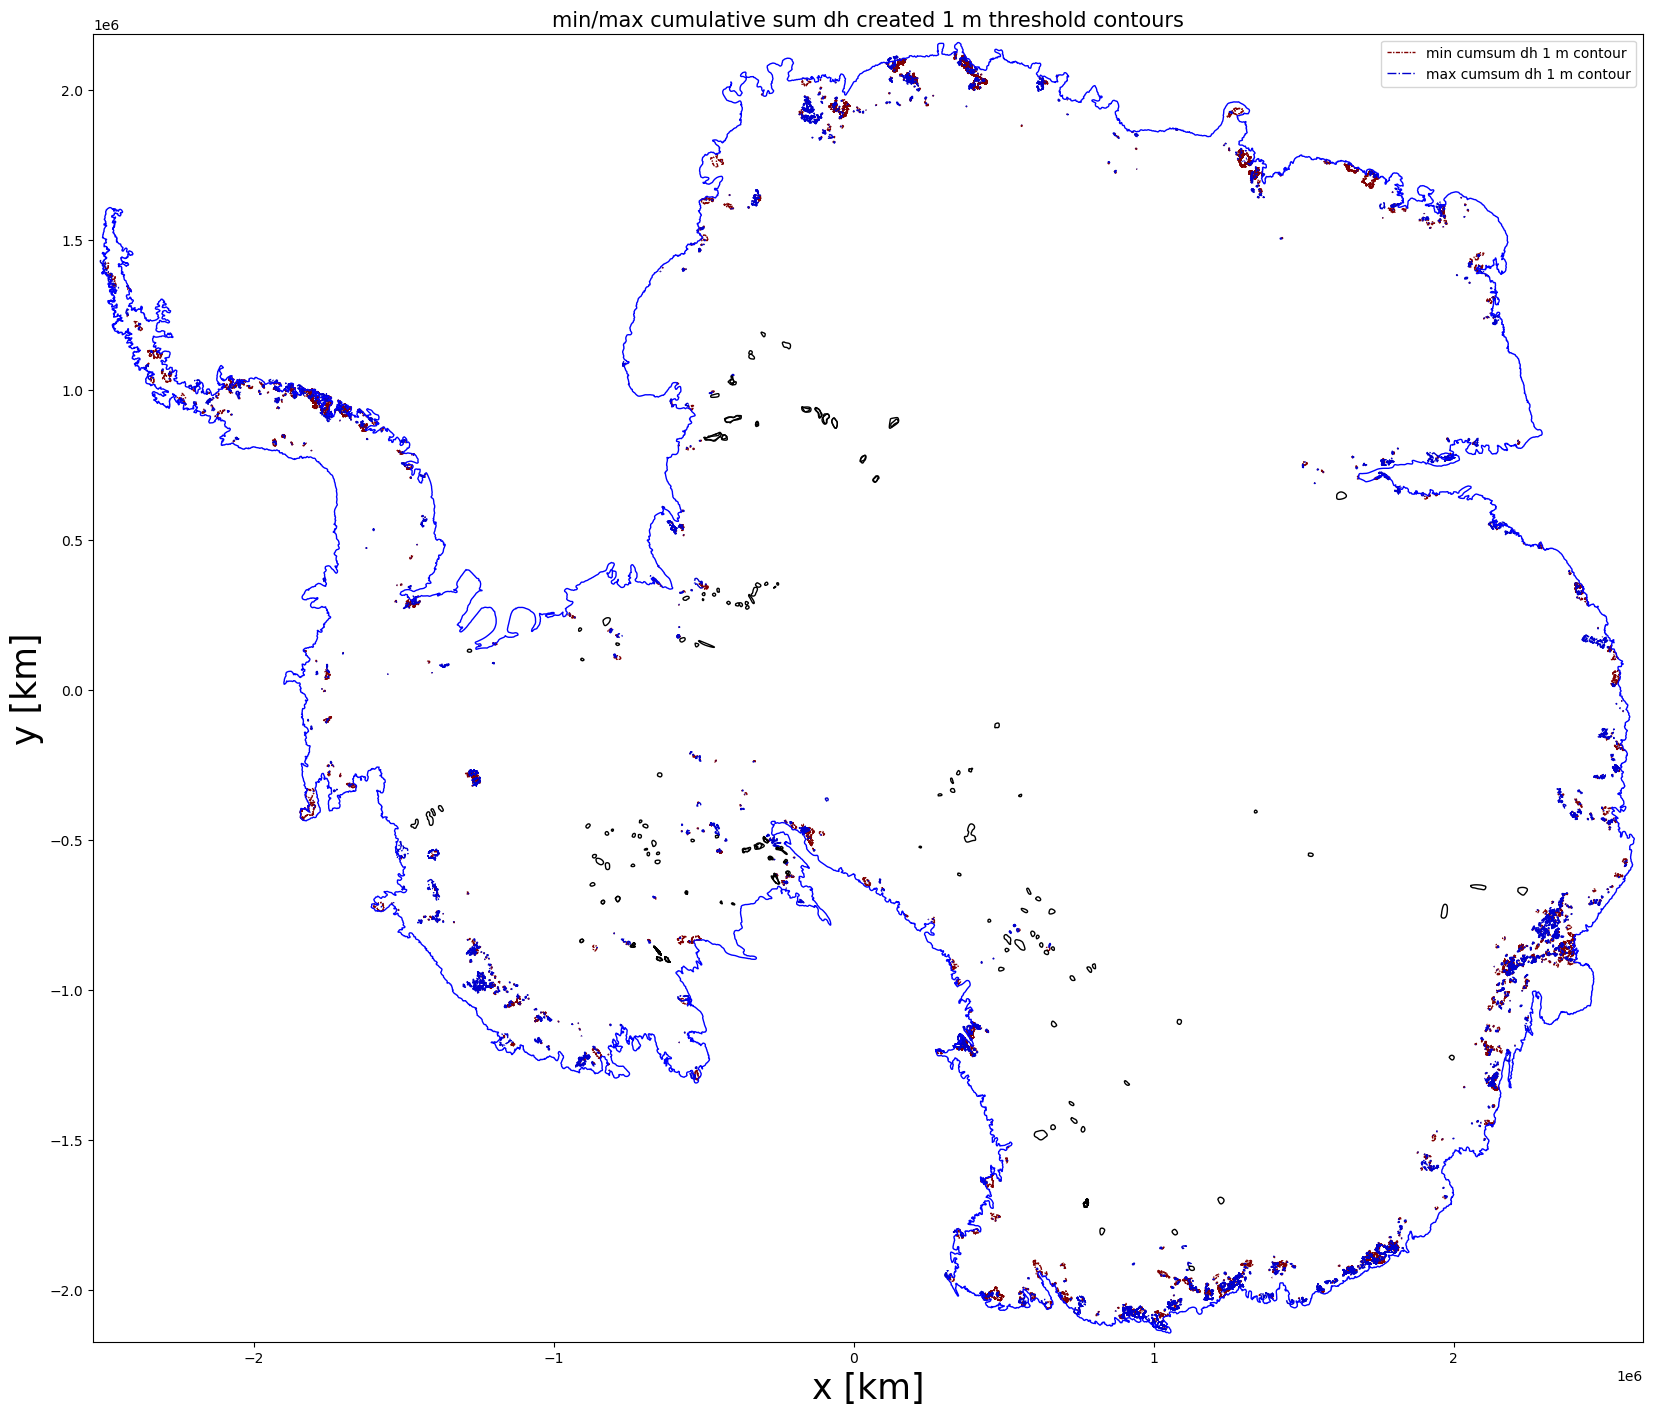

In [354]:
plot_candidates(ATL15_dh, threshold, gdf_cleaned_minmaxintersect)

In [358]:
# Perform overlay to find overlapping polygons
overlapping_polygons = gpd.overlay(gdf_left_reset, gdf_right_reset, how='intersection')

area (km^2)_1  perim (km)_1 min_or_max_1  \
0         77.274351     62.739943          min   
1         77.274351     62.739943          min   
2         77.274351     62.739943          min   
3         77.274351     62.739943          min   
4         29.002182     33.611434          min   
...             ...           ...          ...   
2500       0.101229      1.391759          min   
2501       0.000856      0.153561          min   
2502       6.129828     11.189682          min   
2503       6.129828     11.189682          min   
2504       3.609511      7.566504          min   

                            centroid_1  area (km^2)_2  perim (km)_2  \
0       POINT (338552.277 2116548.090)       0.776680      3.947129   
1       POINT (338552.277 2116548.090)       5.395232     11.354347   
2       POINT (338552.277 2116548.090)       0.057206      1.020572   
3       POINT (338552.277 2116548.090)       0.750153      3.698132   
4       POINT (369558.077 2113072.612)       2.787822      6.299581   
...                                ...            ...           ...   
2500  POINT (1013291.692 -2096920.887)       1.328425      4.653353   
2501   POINT (983325.004 -2103007.383)     161.199954     60.697689   
2502  POINT (1029347.598 -2105194.830)       2.060011      5.554938   
2503  POINT (1029347.598 -2105194.830)      33.492199     37.374299   
2504  POINT (1035494.863 -2122843.167)       0.363946      2.586892   

     min_or_max_2                        centroid_2  \
0             max    POINT (338361.539 2122877.366)   
1             max    POINT (336233.431 2119466.533)   
2             max    POINT (339396.614 2113983.435)   
3             max    POINT (339446.038 2110057.084)   
4             max    POINT (369994.784 2112531.164)   
...           ...                               ...   
2500          max  POINT (1013341.201 -2096084.704)   
2501          max   POINT (979574.698 -2093919.128)   
2502          max  POINT (1029234.879 -2103069.104)   
2503          max  POINT (1026911.527 -2108088.978)   
2504          max  POINT (1036284.802 -2122819.911)   

                                               geometry  
0     POLYGON ((338440.986 2122356.706, 337463.606 2...  
1     POLYGON ((337321.395 2120008.833, 337337.654 2...  
2     POLYGON ((339440.791 2113831.897, 339165.067 2...  
3     POLYGON ((338782.937 2110011.158, 338754.393 2...  
4     POLYGON ((369499.776 2112010.693, 369436.876 2...  
...                                                 ...  
2500  POLYGON ((1013310.824 -2096582.074, 1013417.26...  
2501  POLYGON ((983292.728 -2103009.298, 983316.696 ...  
2502  POLYGON ((1029307.692 -2103379.138, 1029748.81...  
2503  POLYGON ((1030307.497 -2104426.708, 1030637.25...  
2504  POLYGON ((1036305.343 -2122209.940, 1036629.66...  

[2505 rows x 9 columns]

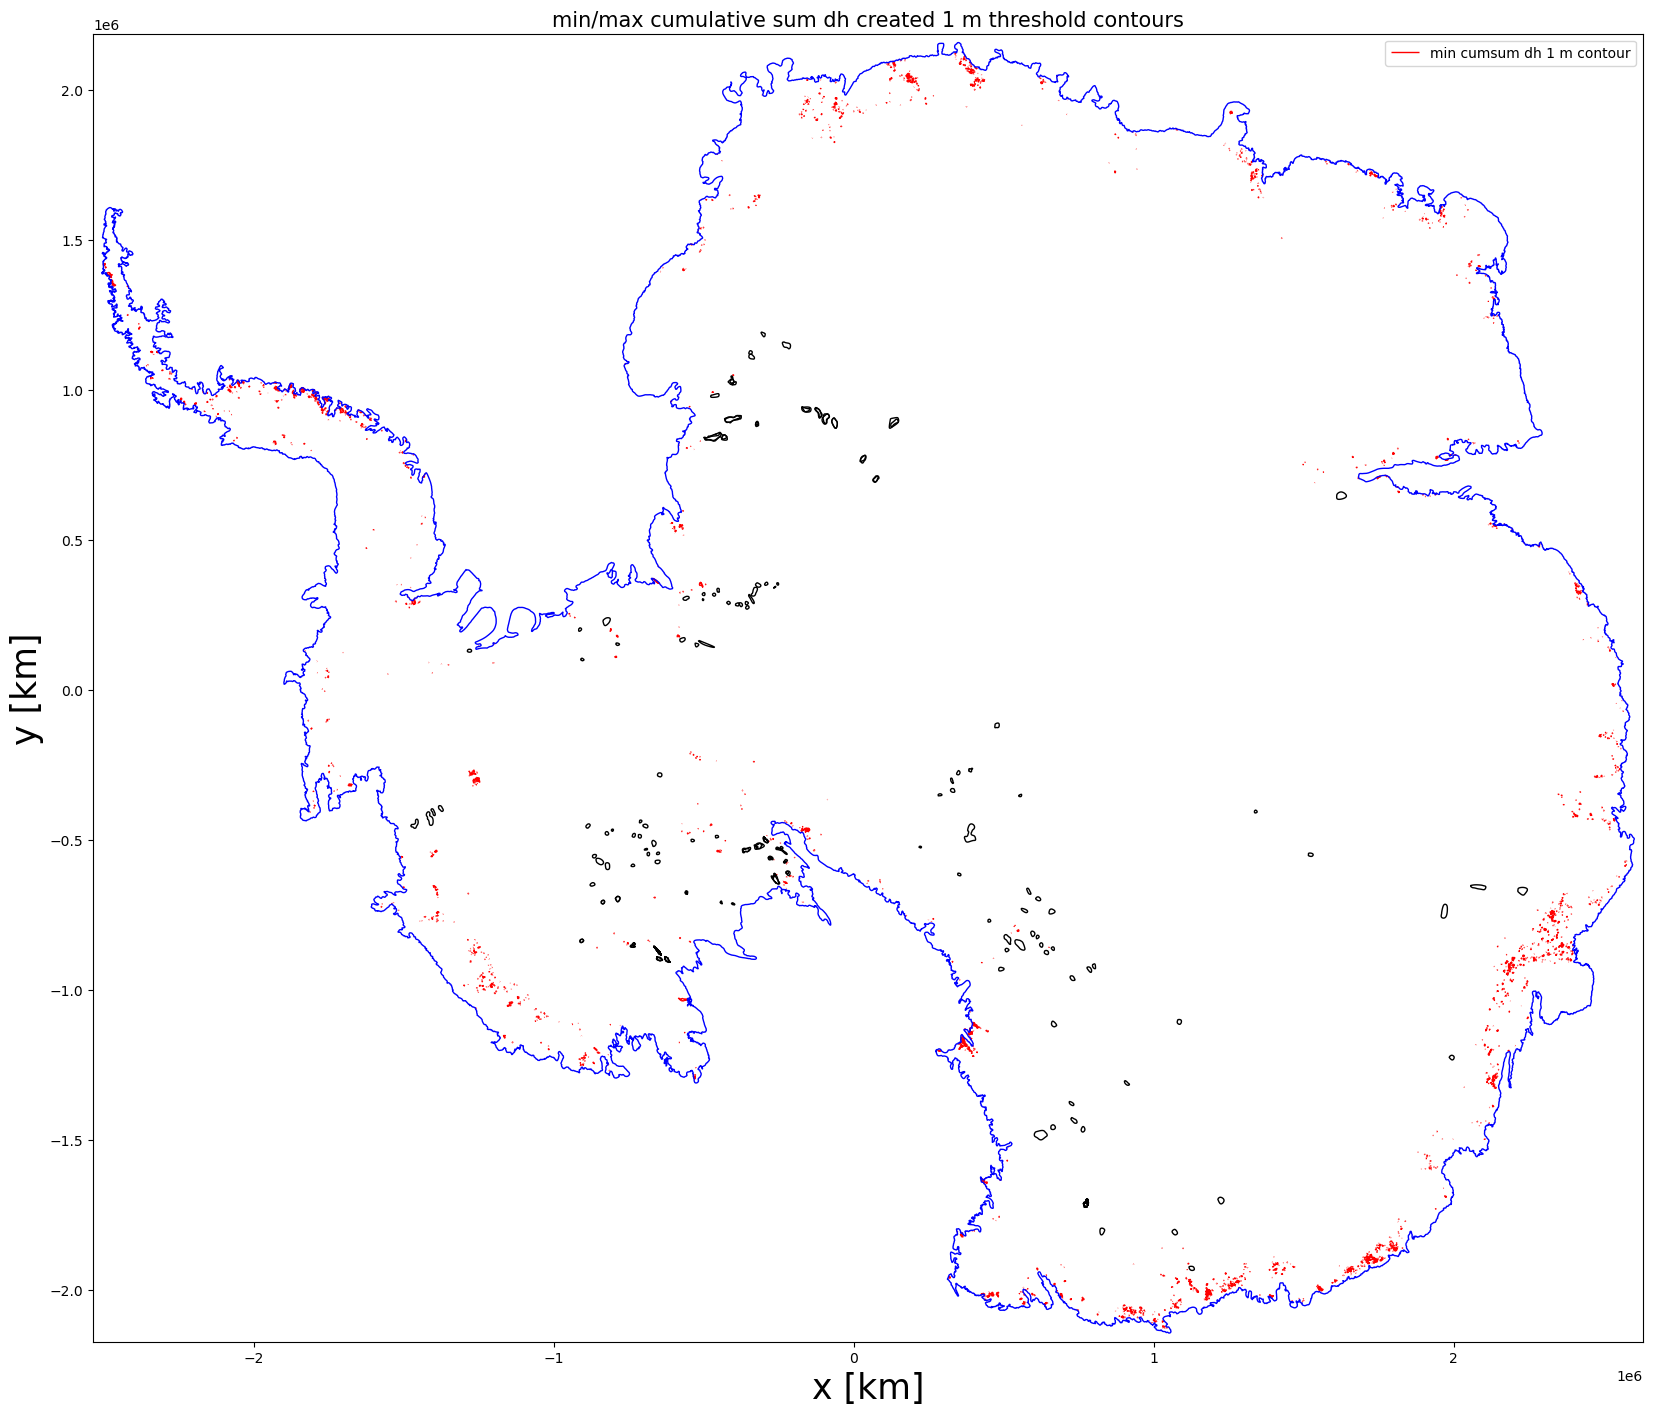

In [363]:
gdf = overlapping_polygons
dataset = ATL15_dh

# Find x, y min, max
x_min, x_max = (dataset['x'].min().values, dataset['x'].max().values)
y_min, y_max = (dataset['y'].min().values, dataset['y'].max().values)

# Visualize the max grand cumulative sums 
fig, ax = plt.subplots(figsize=(20,20))

# Plot the outlines
gdf.boundary.plot(ax=ax, color='red', linestyle='solid', 
        linewidth=1, label='min cumsum dh {} m contour'.format(threshold))

# Overlay published active lake outlines for visual comparison and grounding line
Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

# Label axes set limits
ax.set_xlabel('x [km]', size=25)
ax.set_ylabel('y [km]', size=25)
x_min, x_max = (dataset['x'].min().values-30e3, dataset['x'].max().values+30e3)
y_min, y_max = (dataset['y'].min().values-30e3, dataset['y'].max().values+30e3)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Add legend and title
ax.legend()
ax.set_title('min/max cumulative sum dh created {} m threshold contours'.format(threshold), size=15)
plt.show()

In [ ]:
# finalizing algo with for loop to capture multiple height thresholds

In [ ]:
find_cumsums(ATL15_dh)

thresholds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.75, 0.5]#, 0.25]
# thresholds = [1, 0.75, 0.5]

# Assuming you have an existing GeoDataFrame
gdf_concatenated = gpd.GeoDataFrame(columns=['geometry', 'area (km^2)', 'perim (km)', 'min_or_max', 'centroid'])

for i in thresholds: 
    gdf = find_candidates(ATL15_dh, i)
    print('Working on', i, ' m threshold')
    print(len(gdf), ' contours found')
    # Append the new GeoDataFrame to the existing one
    # gdf_concatenated = gdf_concatenated.append(gdf, ignore_index=True)
    gdf_concatenated = pd.concat([gdf_concatenated, gdf], ignore_index=True)

print('Complete!')
print(len(gdf), ' total contours found')

In [48]:
gdf_subset = gdf_concatenated[gdf_concatenated['area (km^2)'] <= (SiegfriedFricker2018_outlines['area (m^2)'].max()/1e6)]
print(len(gdf_subset))
# Assign metadata
gdf_subset.metadata = {
    'name': 'gdf_subset',
}

238198


In [37]:
ROI = 'Antarctica'

plot_candidates(ROI, ATL15_dh, thresholds, gdf_subset)

In [49]:
# Remove outlines intersecting with previously identified lakes

# Assuming you have two GeoDataFrames
gdf_left = gdf_subset
gdf_left_reset = gdf_left.reset_index(drop=True)
print(len(gdf_left_reset))
gdf_right = SiegfriedFricker2018_outlines
gdf_right_reset = gdf_right.reset_index(drop=True)
print(len(gdf_right_reset))

# Perform a spatial join based on the centroid of gdf_points within gdf_polygons
# joined = gpd.sjoin(gdf_points, gdf_polygons, op='within')
joined = gdf_left_reset.sjoin(gdf_right_reset, how="inner", predicate='intersects')

# Extract the indices of rows in gdf_points that do not have a match in the join
rows_to_remove = joined.index

# Remove the rows from gdf_points
gdf_cleaned = gdf_left_reset.drop(rows_to_remove)
print(len(gdf_cleaned))

# Assign metadata
gdf_cleaned.metadata = {
    'name': 'gdf_cleaned',
}

238198
131
236918


In [39]:
plot_candidates(ROI, ATL15_dh, thresholds, gdf_cleaned)

In [50]:
# Finding intersecting min/max outlines and ignore the rest

# making max the left gdf because more outlines in that gdf
gdf_min = gdf_cleaned[gdf_cleaned['min_or_max'] == 'min']
gdf_min_reset = gdf_min.reset_index(drop=True)
print(len(gdf_min_reset))
gdf_max = gdf_cleaned[gdf_cleaned['min_or_max'] == 'max']
gdf_max_reset = gdf_max.reset_index(drop=True)
print(len(gdf_max_reset))

# Perform a spatial join based on the centroid of gdf_points within gdf_polygons
# joined = gpd.sjoin(gdf_points, gdf_polygons, op='within')
joined = gdf_min_reset.sjoin(gdf_max_reset, how="inner", predicate='intersects')

# Extract the indices of rows in gdf_points that have a match in the join
min_rows_to_keep = joined.index
max_rows_to_keep = joined.index_right.values

# Remove the rows from gdf_points
gdf_min_maxintersect = gdf_min_reset.iloc[min_rows_to_keep]
gdf_max_minintersect = gdf_max_reset.iloc[max_rows_to_keep]
gdf_minmaxintersect = pd.concat([gdf_min_maxintersect, gdf_max_minintersect], ignore_index=True)
print(len(gdf_minmaxintersect))

# Assign metadata
gdf_minmaxintersect.metadata = {
    'name': 'gdf_minmaxintersect',
}

99765
137153
109434


In [41]:
# plot_candidates(ROI, ATL15_dh, thresholds, gdf_min_maxintersect)

In [42]:
# plot_candidates(ROI, ATL15_dh, thresholds, gdf_max_minintersect)

In [43]:
plot_candidates(ROI, ATL15_dh, thresholds, gdf_minmaxintersect)

In [51]:
# Perform overlay to find overlapping polygons
gdf_intersection = gpd.overlay(gdf_min_maxintersect, gdf_max_minintersect, how='intersection')
print(len(gdf_intersection))

# Assign metadata
gdf_intersection.metadata = {
    'name': 'gdf_intersection',
}

1407350


In [ ]:
# Export lake candidates geodataframe


In [45]:
plot_candidates(ROI, ATL15_dh, thresholds, gdf_intersection)

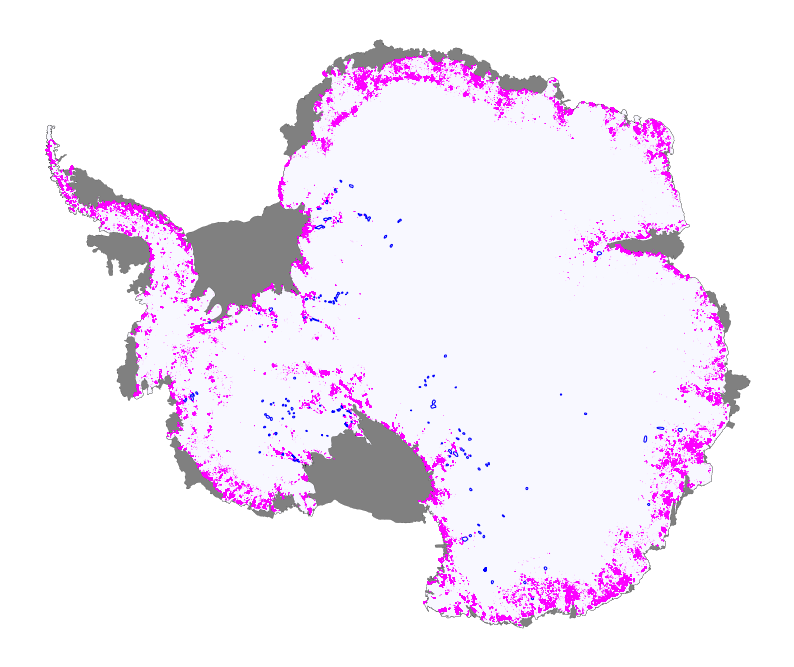

In [53]:
# Plot simplified view of previously identified lakes and lake candidates for NDSEG 2024 app
# Plot inset map to show location 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
moa_2014_coastline.plot(ax=ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, edgecolor='blue', linestyle='solid', linewidth=0.75, zorder=2)
gdf_intersection.boundary.plot(ax=ax, color='magenta', linestyle='solid', linewidth=0.25, label='lake candidates', zorder=2)
# for i in ['Jpp-K', 'J-Jpp', 'G-H']: 
#     IMBIE_basins[IMBIE_basins['NAME'] == i].boundary.plot(ax=ax, color='k', linestyle='solid', linewidth=1)
ax.axis('off')

plt.show()

* find dh range by differencing the max and min dh cumsum (but some of range will be the overlap of uplift and lowering)

In [77]:
# trying finding dh range using diff between max and min dh cumsum
find_cumsums(ATL15_dh)

In [78]:
ATL15_dh['minmaxcumsumdiff'] = ATL15_dh.dh_grand_cumsum[1] - ATL15_dh.dh_grand_cumsum[0]

In [ ]:
thresholds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.75, 0.5, 0.25, 0.1]
for i in thresholds:
    gdf = find_candidates_minmaxcumsumdiff('A4', ATL15_dh, i)

# Assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
ATL15_dh = ATL15_dh.assign(h = ATL15_dh['delta_h'] + ATL14['h'][:,:])
ATL15_dh* or using absolute heights at each cycle and finding the max and min absolute height, then differencing (i don't think this would work for high accumulation or ablation regions where the range would high)

In [ ]:
ATL15_dh['h_range'] = ATL15_dh.h.max() - ATL15_dh.h.min()

## Other ideas: 

* further filter signal by looking at 3 or 4 pi (more than one osscilation)
* filter to make sure it goes uplift, lowering, uplift, lowering sequentially (are there any lakes that have lowering repeated by lowering?)
* filter by seasonality? perhaps simplify to winter/summer seasons
* everything in a basin/region has min and max at same time? are they synchrous or sequential or random (latter two would be water driven)
* filter for a min area of lake (because perhaps we don't care about really small lakes because not large vol percentage of system?)
* don't go as low in height threshold for similar reasoning of not caring about smaller signals